In [1]:


%matplotlib inline
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import shap
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE



# Introduction:

In my approach to credit card fraud detection, I treat it as a binary classification problem. However, the nature of credit card fraud detection makes it challenging to build an optimal decision boundary due to the heavily imbalanced distribution of the data. To tackle this challenge, I follow a step-by-step approach.Firstly, I explore the distribution of data variables with respect to fraud and non-fraud transactions to gain insights into the data. Secondly, I use a simple statistical model such as logistic regression to understand the influence of different variables on fraud transactions.Next, I expand the model to a more flexible one, employing feature selection techniques and under-sampling the majority class to improve the model's ability to predict fraud. I also demonstrate how boosting models like Lightgbm can be used to enhance model performance. In addition, I employ the use of Shapley values to explain the model predictions, which yields actionable insights for the business. Finally, I conclude with a discussion of the findings and actionable insights.


The notebook comprises the following steps:

 - Data Exploration.
 - Modeling.
  - Statistical Analysis.
    - Logistic Regression.
        - Feature Selection.
                - Recursive Feature Elimination.
        - Under Sampling the Majority Class.
  - Complex Model.
  - Explainable AI.
  - Conclusion, Discussion and Actionable Insights.

# Reusable Helper Functions:

In [2]:

def get_dataframe_from_summary(est):
    results_summary = est.summary()
    results_as_html = results_summary.tables[1].as_html()
    return pd.read_html(results_as_html, header=0, index_col=0)[0]


def get_regressor_coefficients(model, columns):
    coefficients = {}
    for coefficient, feature in zip(model.coef_, columns):
        coefficients[feature] = coefficient

    return coefficients


def ge_learning_curve(model, x, y, cv, scoring='f1'):
    learning_curve(model, x, y, cv=cv, scoring=scoring)


def get_FeatureImportances(model, X, y):
    # Instantiate the visualizer with the classification model
    viz = FeatureImportances(model)
    viz.fit(X, y)
    viz.show()


def get_ROCAUC(model, x_train, y_train, x_test, y_test, classes):
    # Instantiate the classification model and visualizer
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)  # Evaluate the model on the test data
    visualizer.show()


def get_PrecisionRecallCurve(model, x_train, y_train, x_test, y_test):
    # The PrecisionRecallCurve visualizer taxes a model
    viz = PrecisionRecallCurve(model)

    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    viz.fit(x_train, y_train)

    # To create the PrecisionRecallCurve, we need some test data. Score runs predict() on the data
    # and then creates the precision-recall curve.
    viz.score(x_test, y_test)

    # How did we do?
    viz.show()


def get_ConfusionMatrix(model, x_train, y_train, x_test, y_test):
    # The ConfusionMatrix visualizer taxes a model
    cm = ConfusionMatrix(model, classes=["non_fraud", "fraud"])

    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(x_train, y_train)

    # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
    # and then creates the confusion_matrix from scikit-learn.
    cm.score(x_test, y_test)

    # How did we do?
    cm.show()


def get_DiscriminationThreshold(model, X, y):
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X, y)  # Fit the data to the visualizer
    visualizer.show()


def feature_importance_plot(importances, feature_labels, ax=None):
    importa = pd.DataFrame({"Importance": importances,
                            "Feature": feature_labels})

    importa.sort_values("Importance", inplace=True, ascending=False)
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x="Importance", y="Feature", ax=axis, data=importa)
    axis.set_title('Feature Importance Measures')
    plt.close()

    return axis if ax else fig


# Data Exploration:

In [3]:

data = pd.read_csv("data/creditcard.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:

data.describe()


Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.473120e-16  8.042109e-16  5.282512e-16  4.456271e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   1.426896e-15  1.701640e-15 -3.662252e-16 -1.217809e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

In [5]:

data.head()


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

<AxesSubplot: title={'center': 'Class Distribution are heavily imbalanced'}>

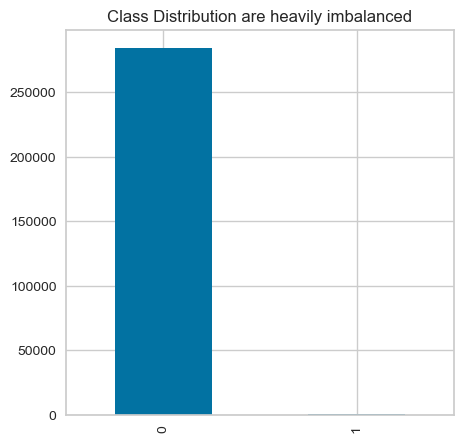

In [6]:
plt.figure(figsize=(5, 5))
data["Class"].value_counts().plot(kind="bar",title="Class Distribution are heavily imbalanced")


<AxesSubplot: title={'center': 'Time Distribution '}, ylabel='Frequency'>

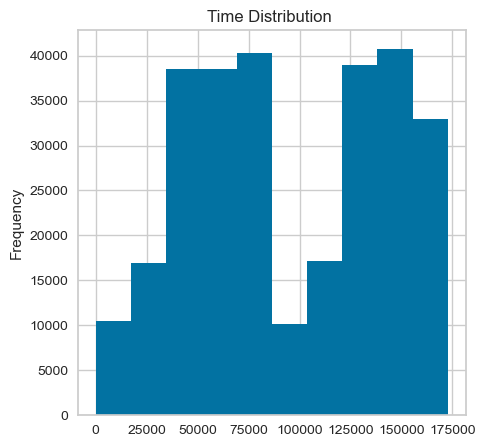

In [7]:

plt.figure(figsize=(5, 5))
data["Time"].plot(kind="hist",title="Time Distribution ")


<AxesSubplot: title={'center': 'Amount Distribution Most of the transactions are small'}, ylabel='Frequency'>

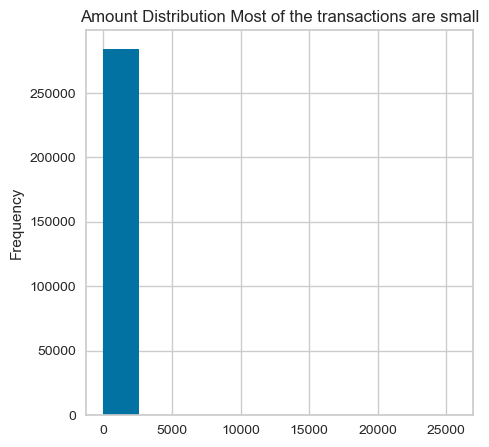

In [8]:
plt.figure(figsize=(5, 5))

data["Amount"].plot(kind="hist",title="Amount Distribution Most of the transactions are small")


correlation matrix

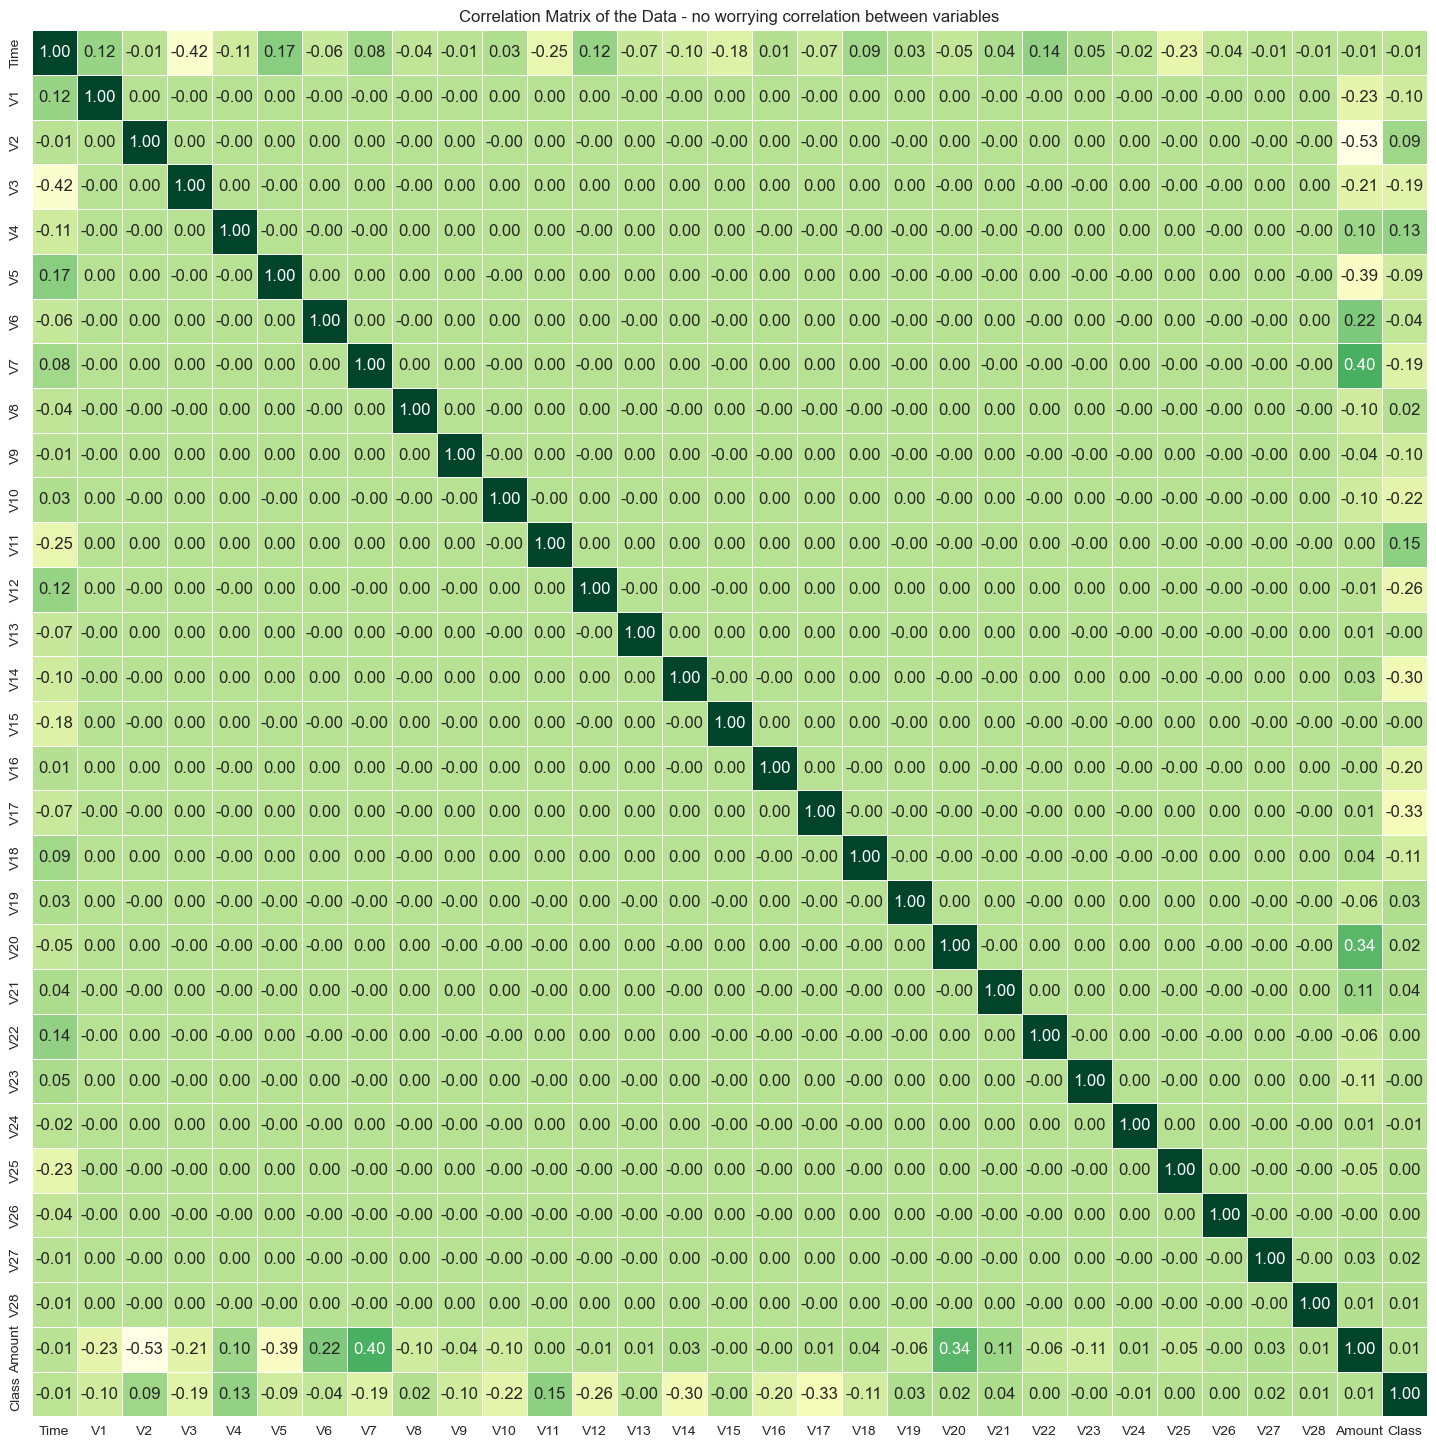

In [9]:

# Create a correlation matrix
corr= data.corr()
# Create a heatmap to visualize the correlation matrix

# Set the figure size:
plt.figure(figsize=(18, 18))
sns.heatmap(corr, cmap="YlGn", annot=True, fmt=".2f", linewidths=0.5, cbar=False).set(title="Correlation Matrix of the Data - no worrying correlation between variables")
# Show the plot
plt.show()



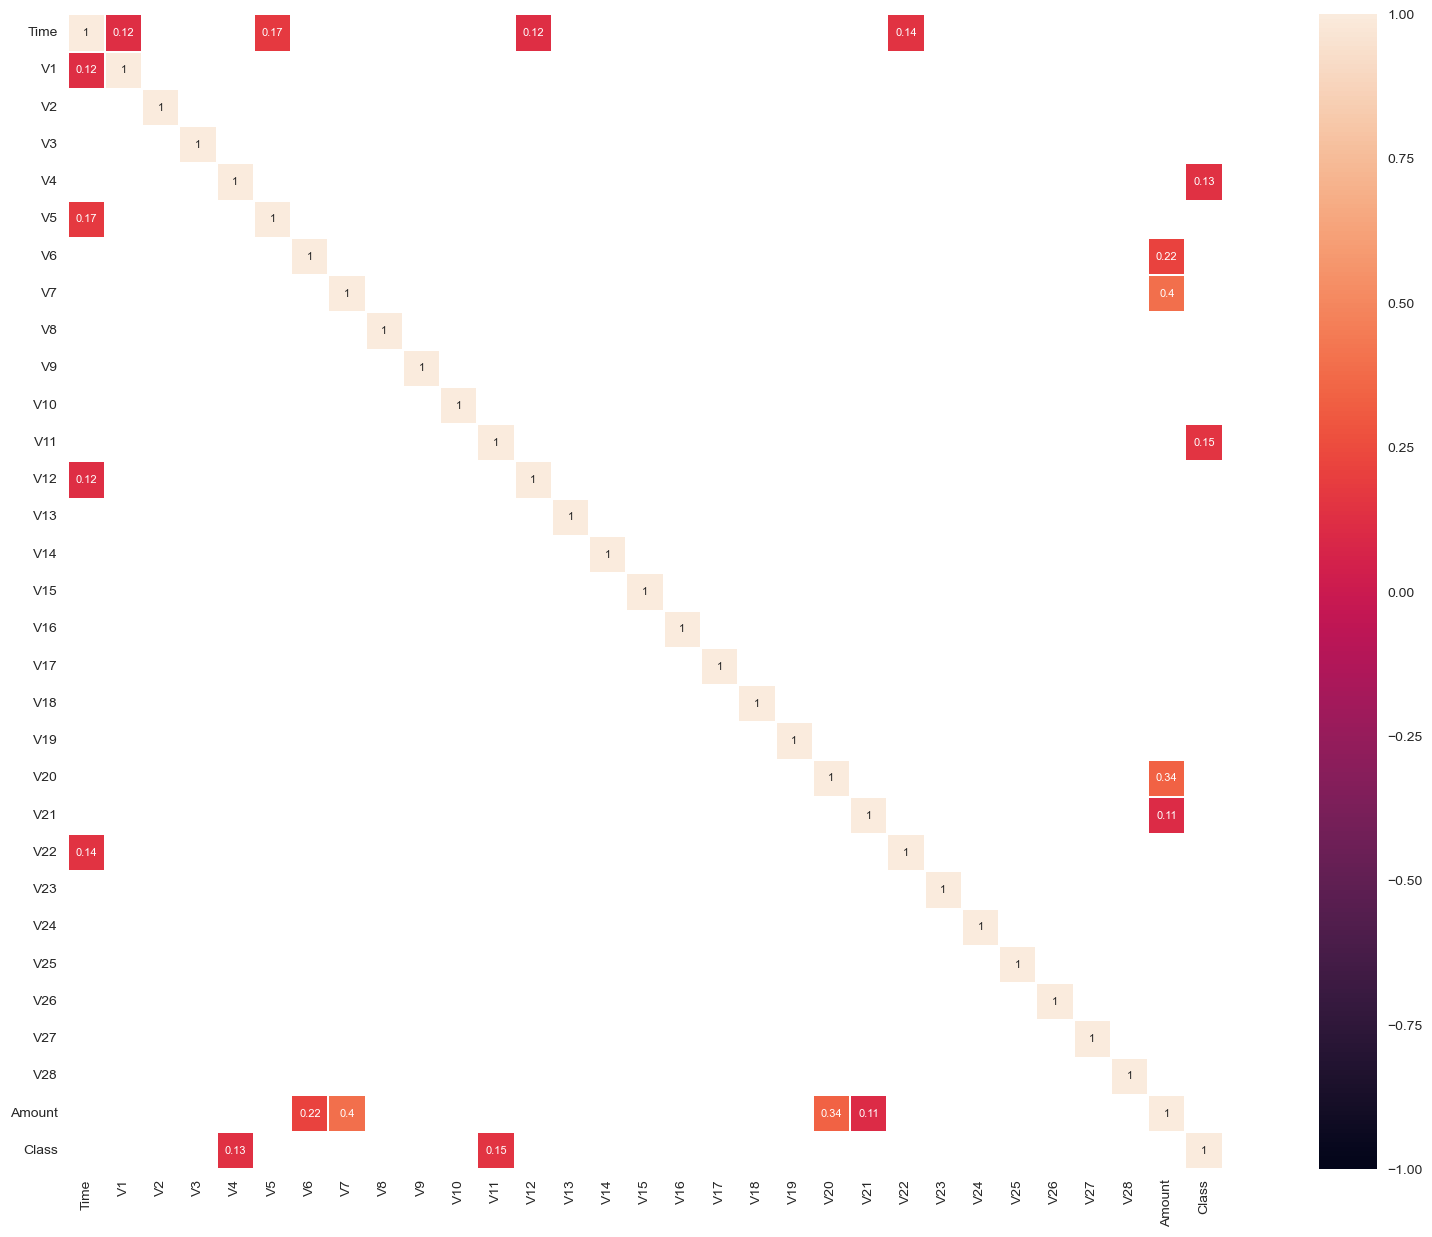

In [10]:

corr = data.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(corr[(corr >= 0.1)], vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True);


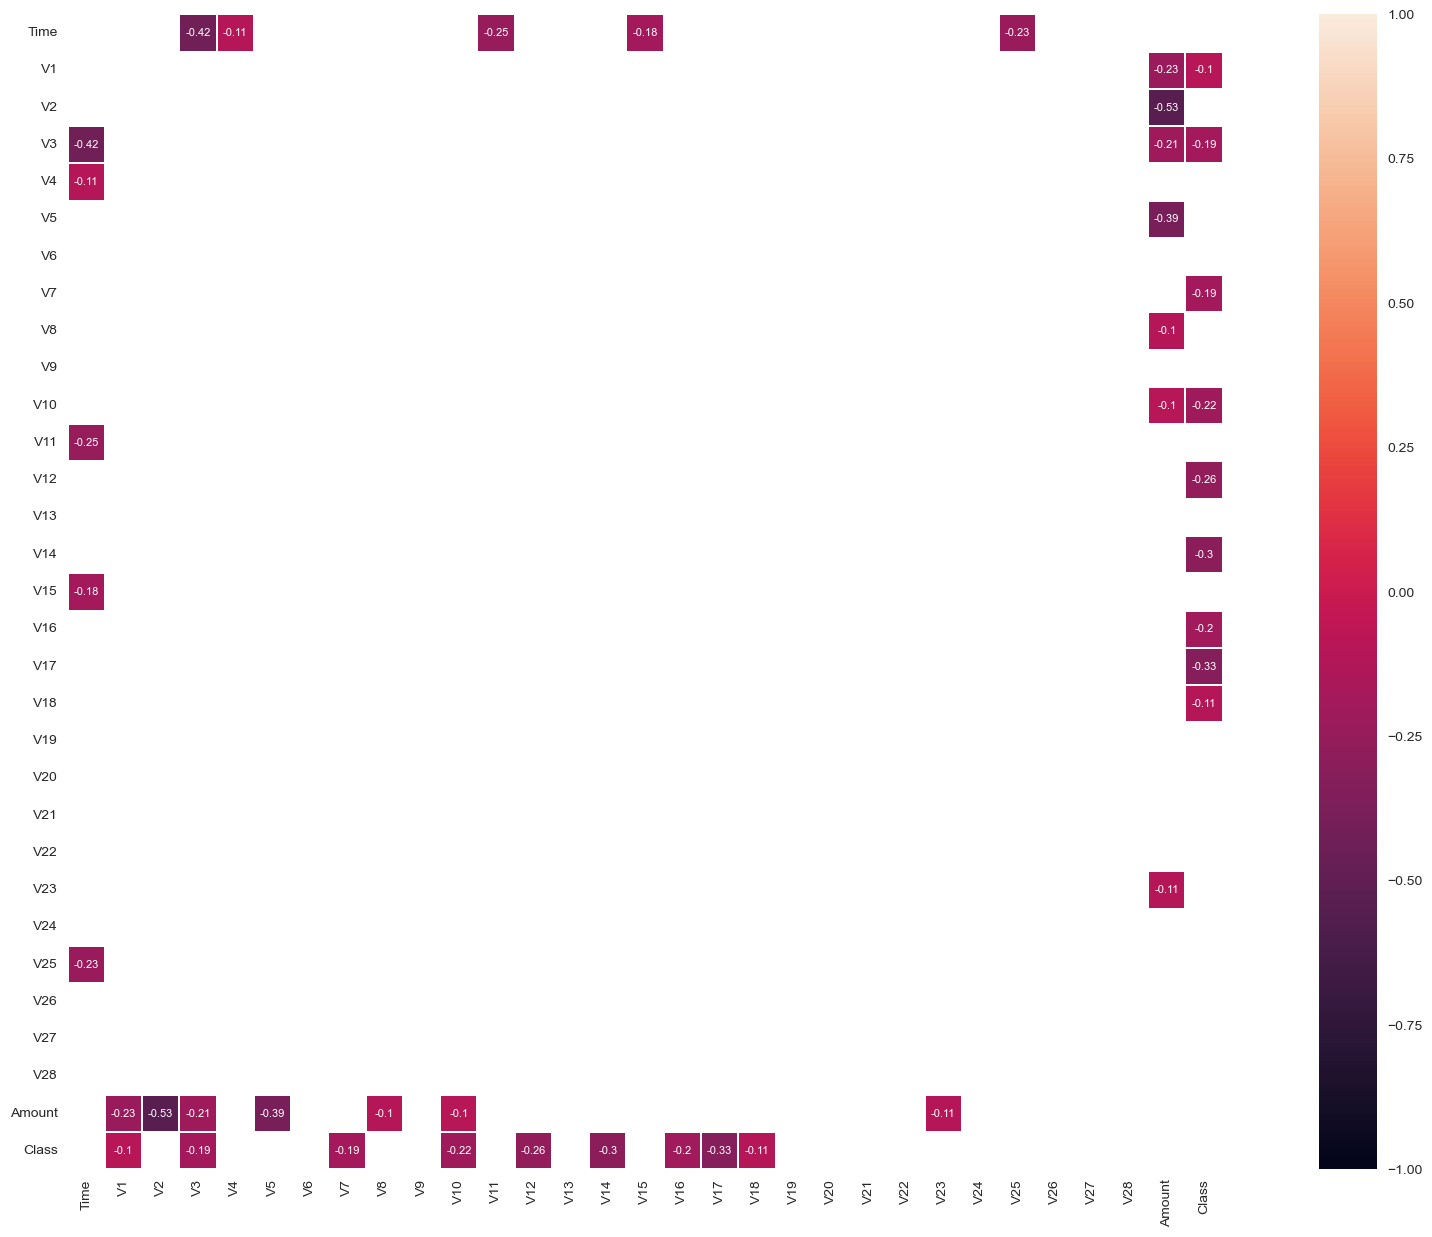

In [11]:

corr = data.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(corr[(corr <= -0.1)], vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True);


correlation with target variable:

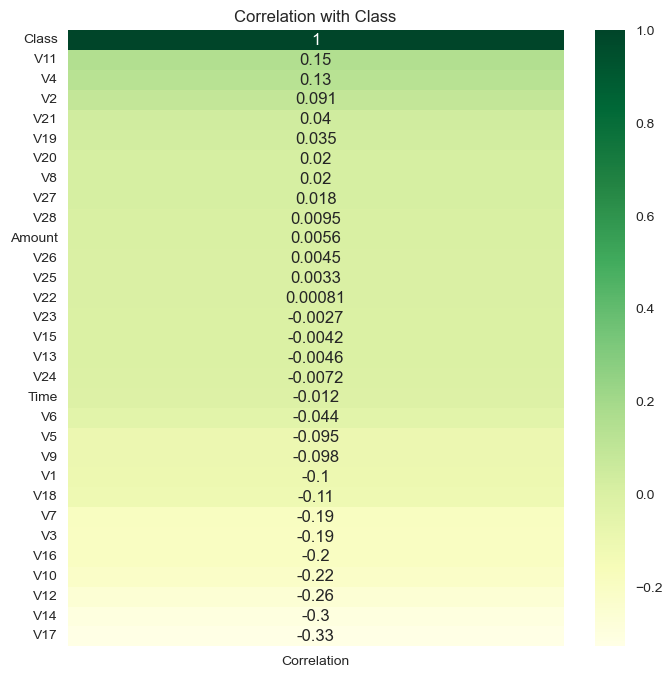

In [12]:

# Create a new DataFrame containing only the correlations between the target variable and the other variables
corr_with_target = data.corrwith(data['Class'])

# Convert the Series to a DataFrame and drop any missing values
corr_df = pd.DataFrame(corr_with_target, columns=['Correlation'])
corr_df.dropna(inplace=True)

# sort the DataFrame by the correlation values:
corr_df.sort_values(inplace=True,by="Correlation",ascending=False)

plt.figure(figsize=(8, 8))

# Create a correlation plot using the new DataFrame
sns.heatmap(corr_df, cmap="YlGn", annot=True).set(title="Correlation with Class")
# Show the plot
plt.show()


let's see if scaling amount and time variables has any effect on the correlation:


[Text(0.5, 1.0, 'Correlation with Class after scaling')]

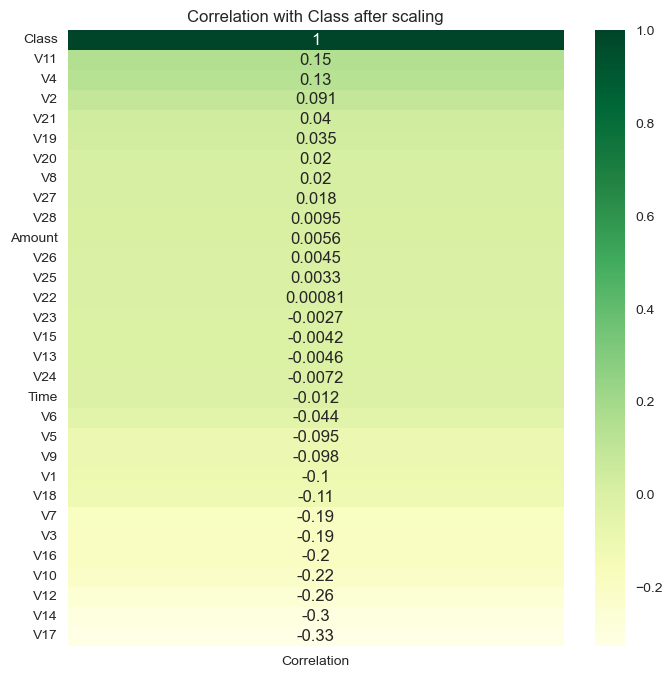

In [13]:

col_to_scale = ["Time","Amount"]
scaler = StandardScaler()

# copy to keep track of the original data:
copied_data = data.copy()
copied_data[col_to_scale] = scaler.fit_transform(copied_data[col_to_scale])

# visualize the correlation again:

# Create a new DataFrame containing only the correlations between the target variable and the other variables
corr_with_target = copied_data.corrwith(data['Class'])

# Convert the Series to a DataFrame and drop any missing values
corr_df = pd.DataFrame(corr_with_target, columns=['Correlation'])
corr_df.dropna(inplace=True)

# sort the DataFrame by the correlation values:
corr_df.sort_values(inplace=True,by="Correlation",ascending=False)

plt.figure(figsize=(8, 8))

# Create a correlation plot using the new DataFrame
sns.heatmap(corr_df, cmap="YlGn", annot=True).set(title="Correlation with Class after scaling")
# Show the plot


Dimensionality Reduction and Visualization of the data variables with respect to the target variable:

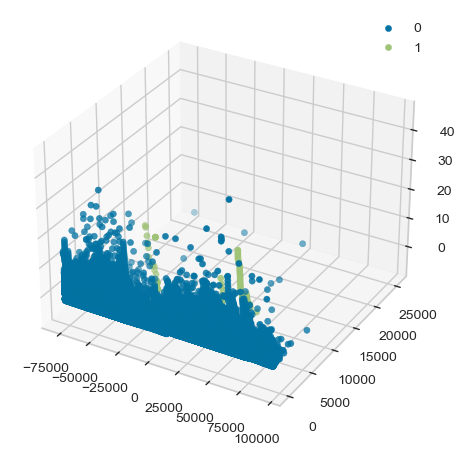

In [14]:

X = data.drop(columns='Class')
pca = PCA(n_components=3)
components = pca.fit_transform(X)

components = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3'])
components["Class"] = data["Class"]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in components.Class.unique():
    ax.scatter(components.PC1[components.Class==s],
               components.PC2[components.Class==s],
               components.PC3[components.Class==s],
               label=s)

ax.legend()


Understand the data from numerical columns distributions and target variable distribution:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


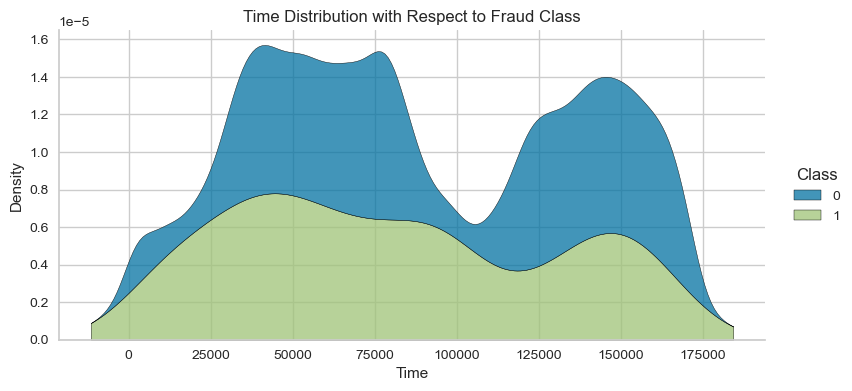

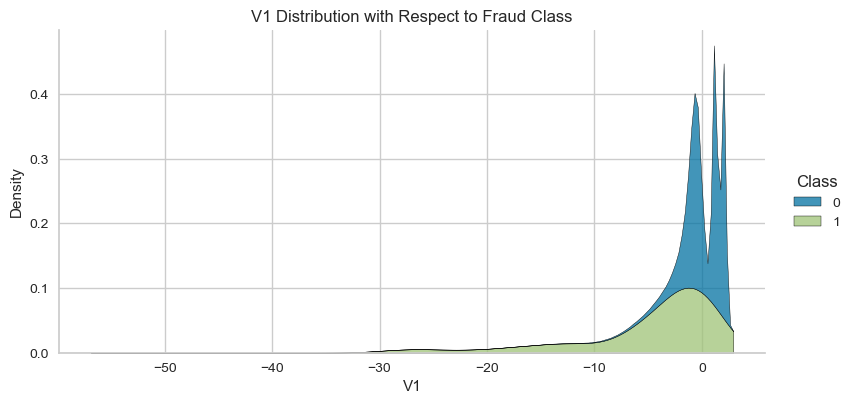

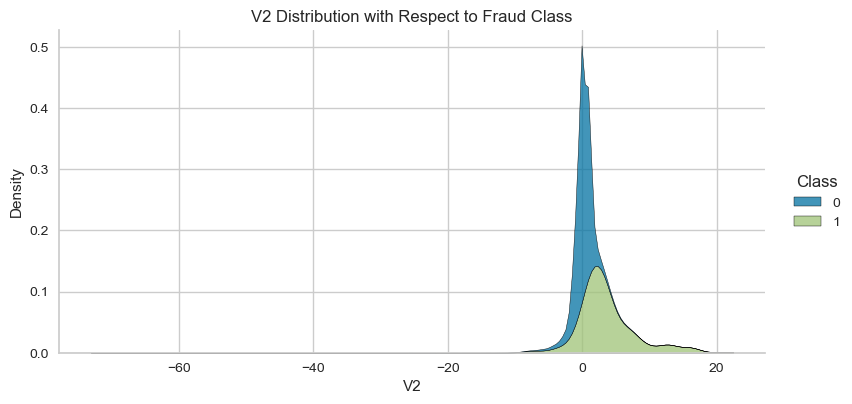

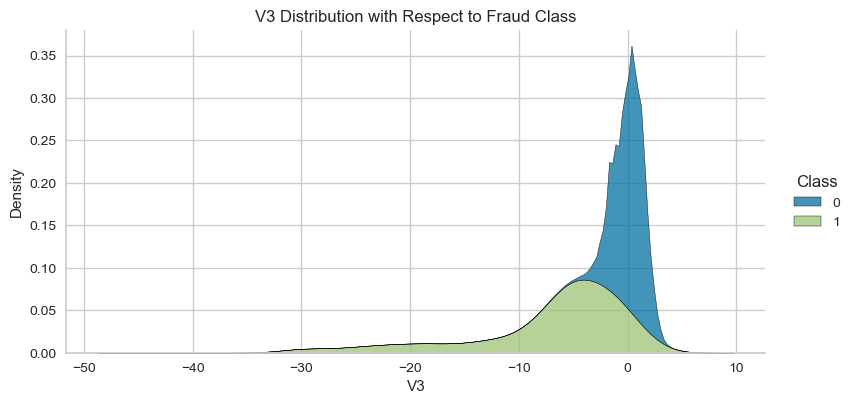

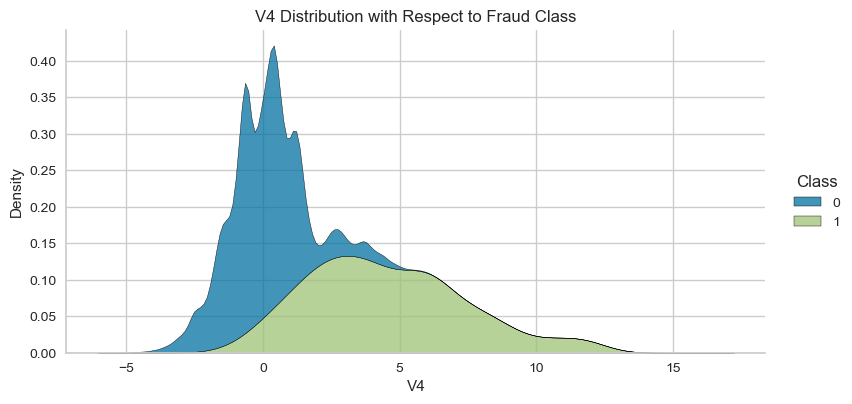

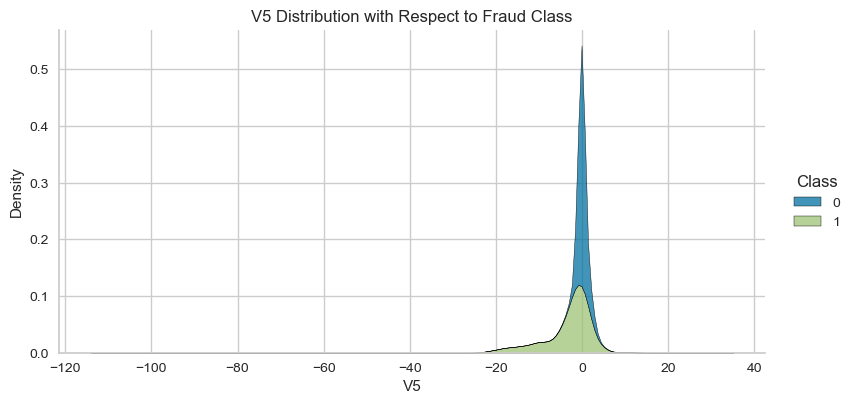

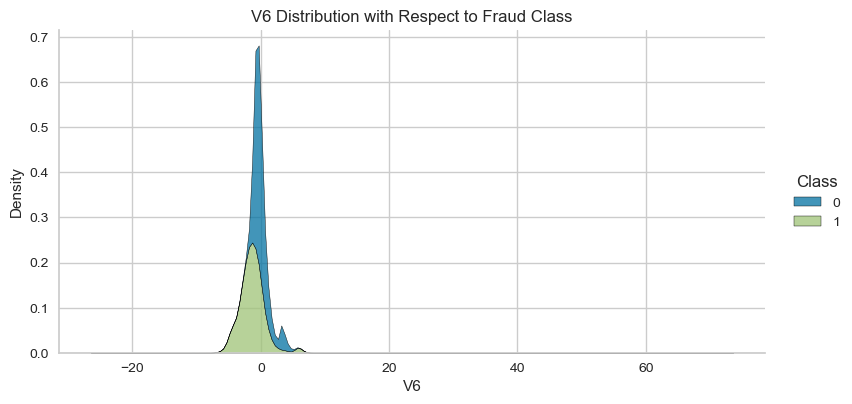

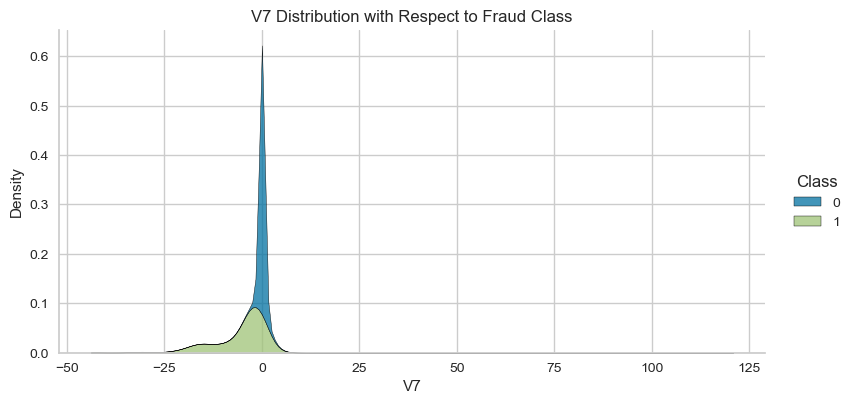

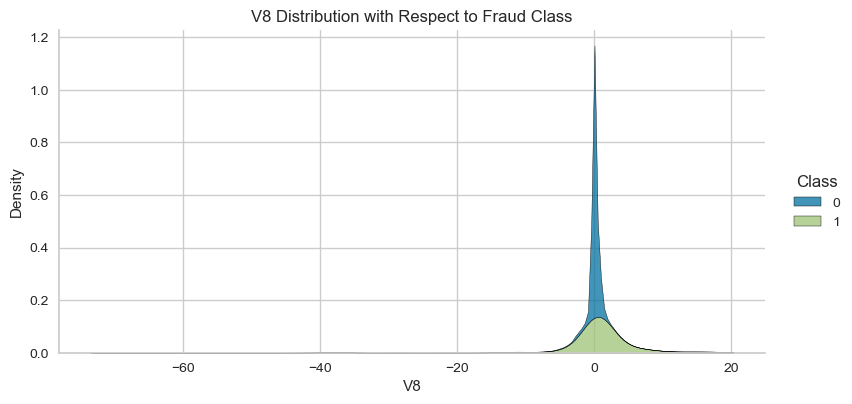

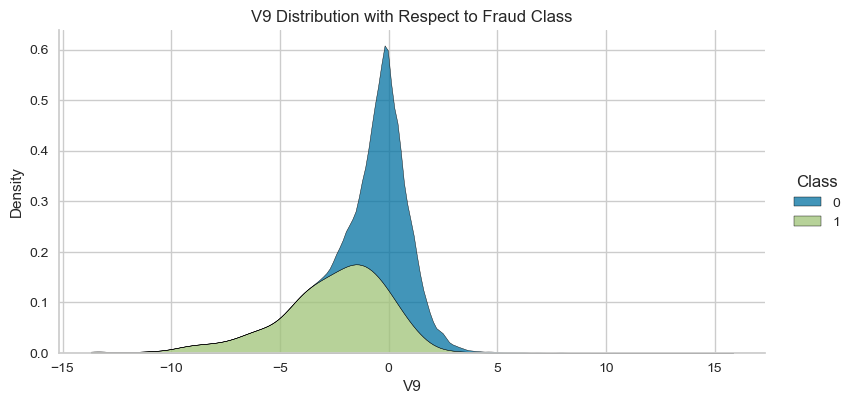

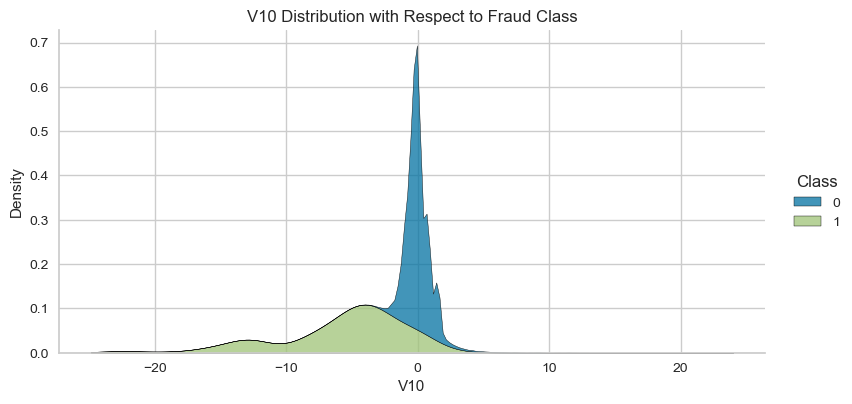

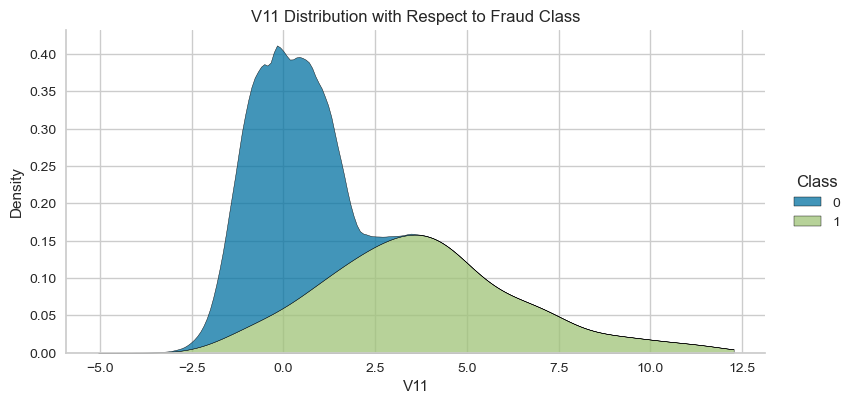

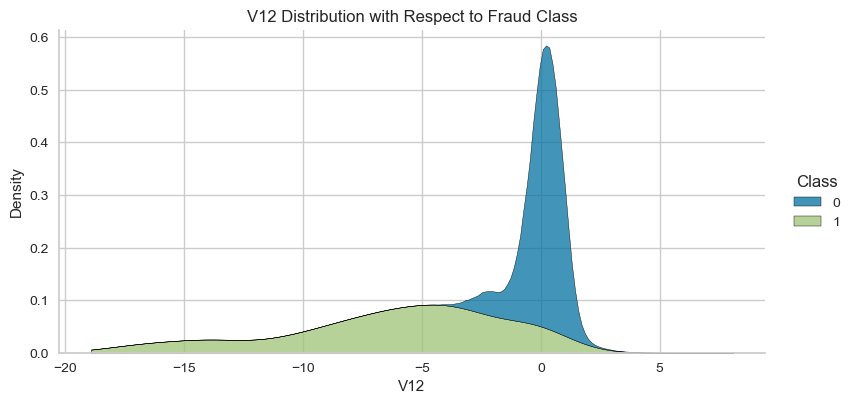

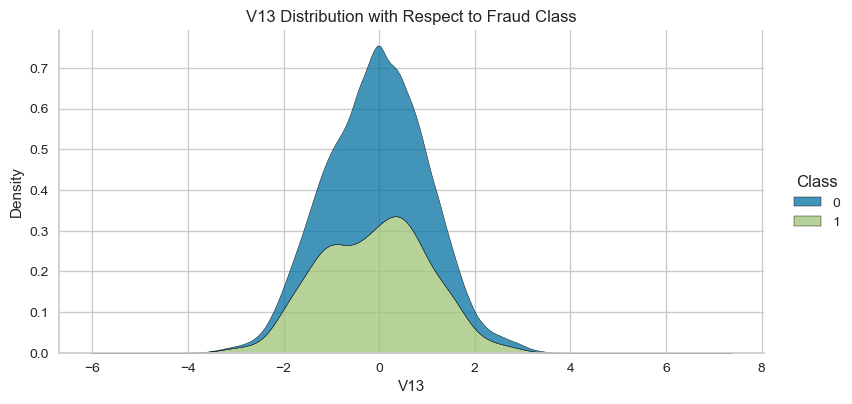

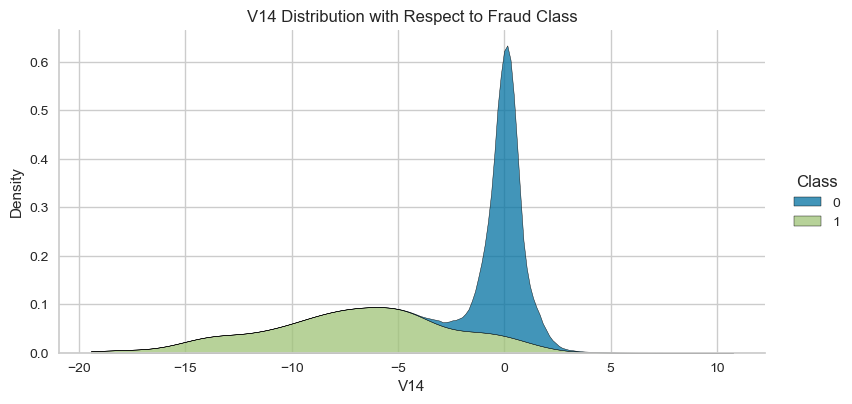

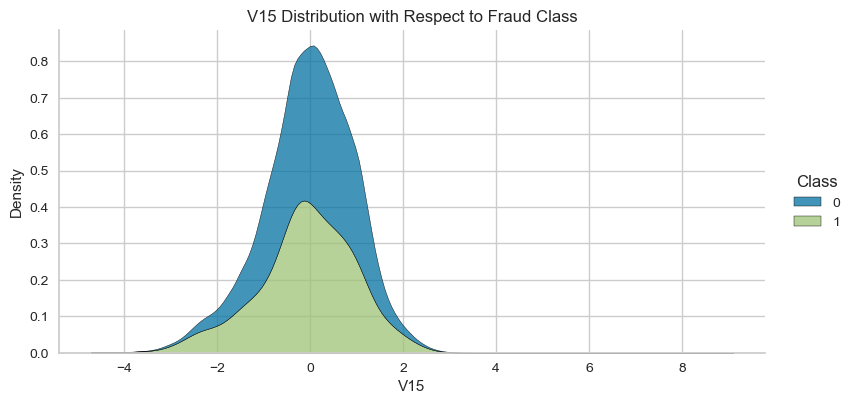

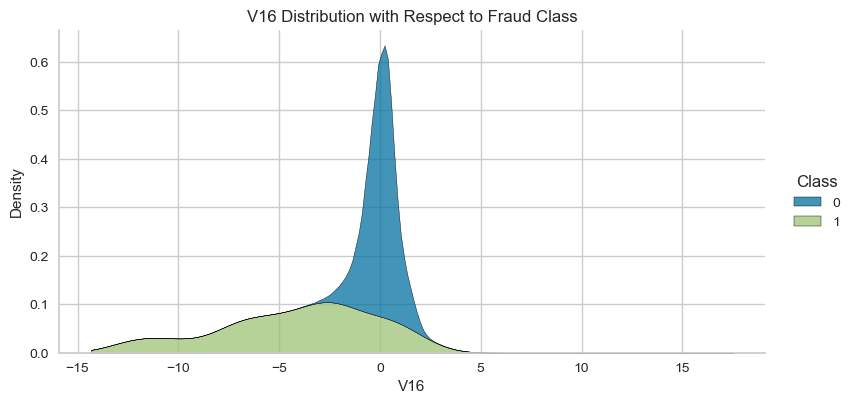

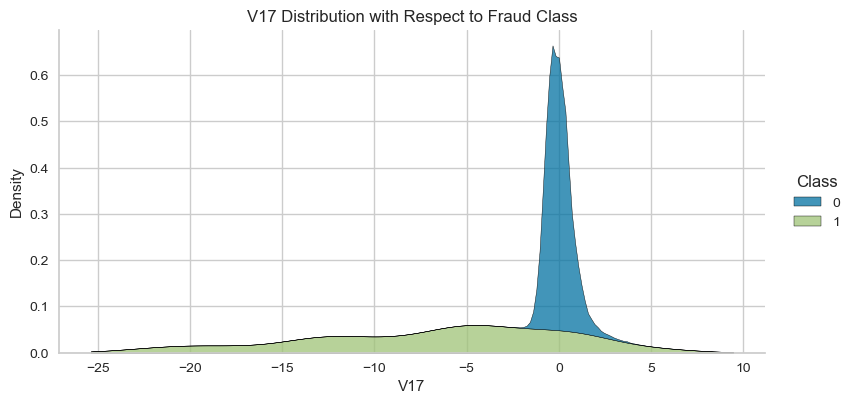

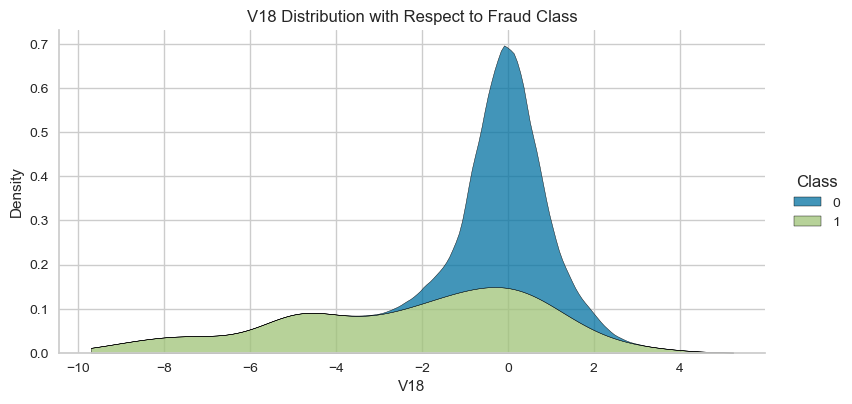

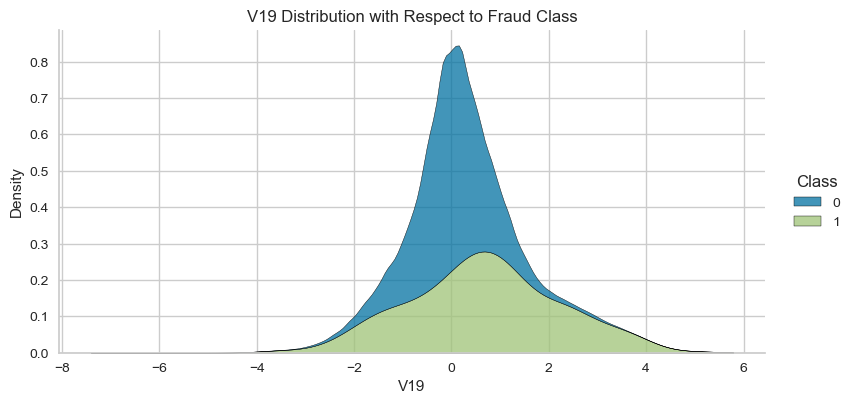

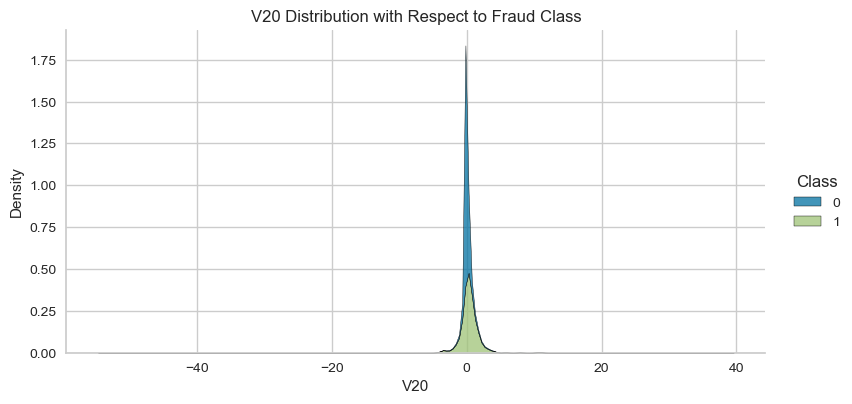

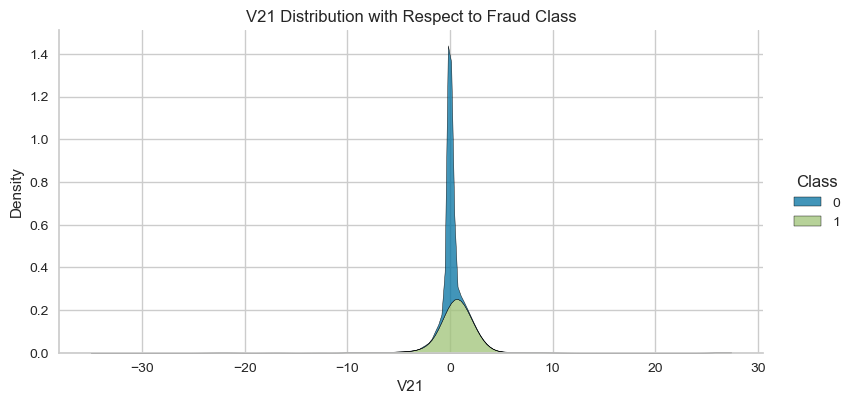

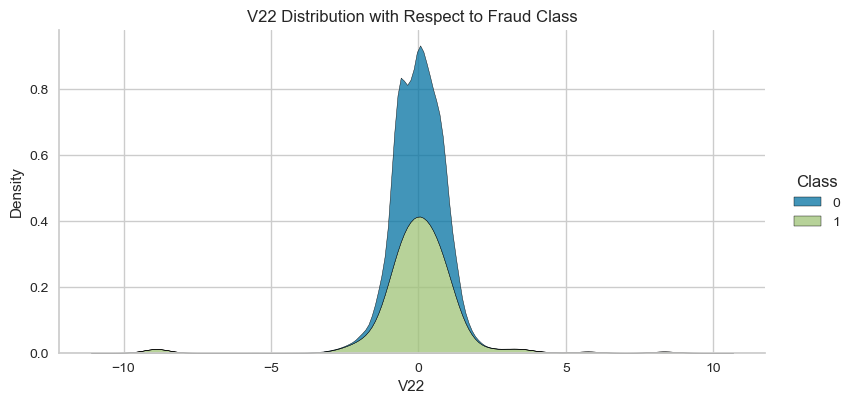

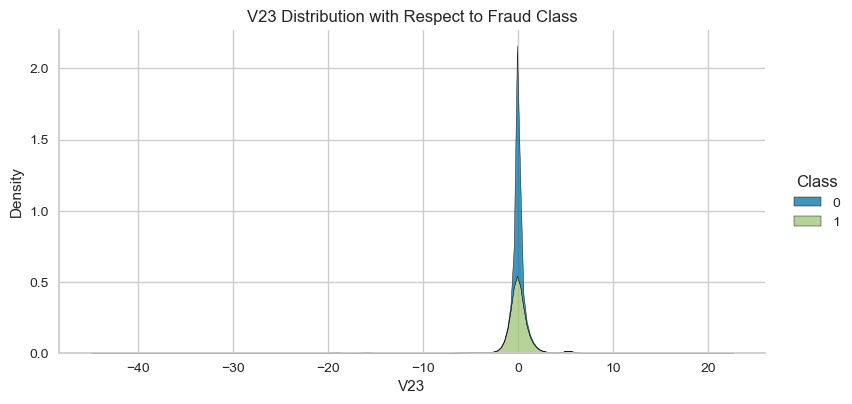

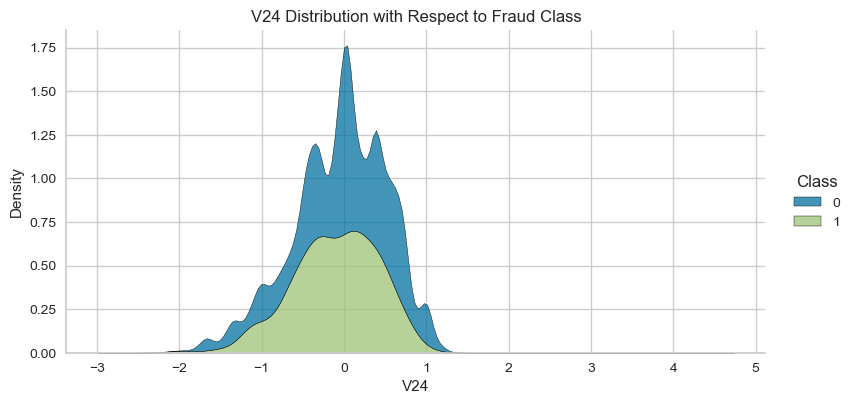

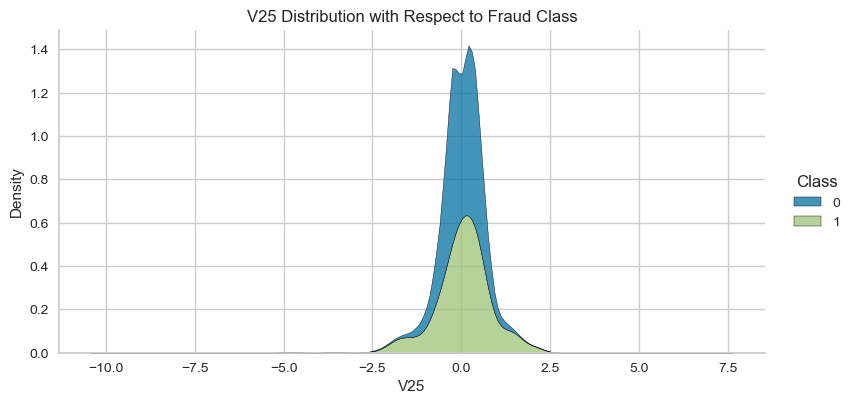

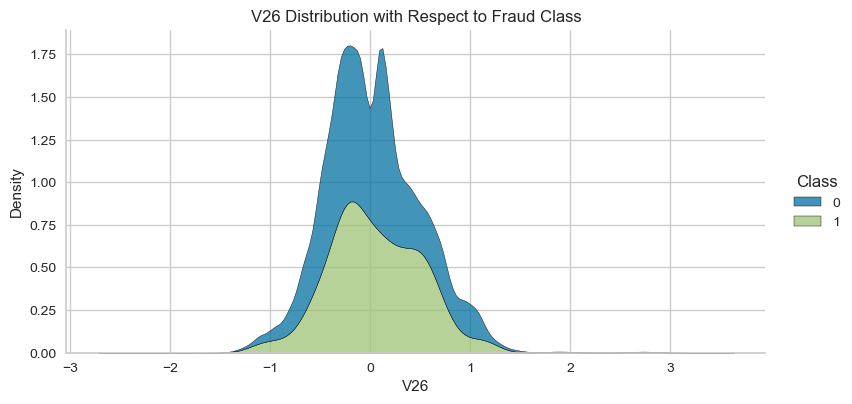

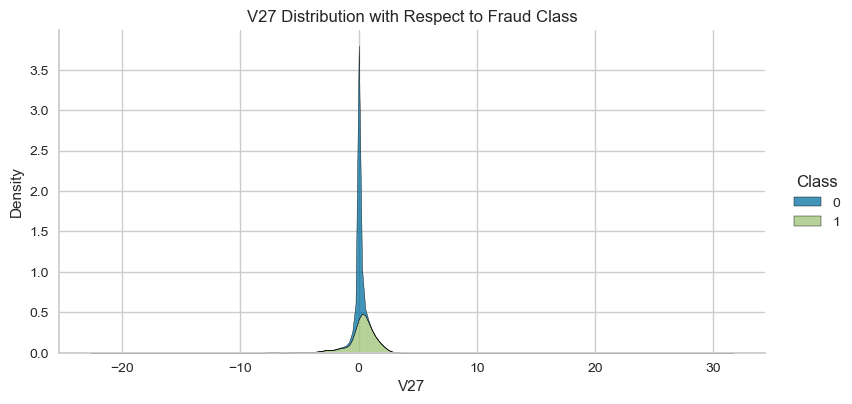

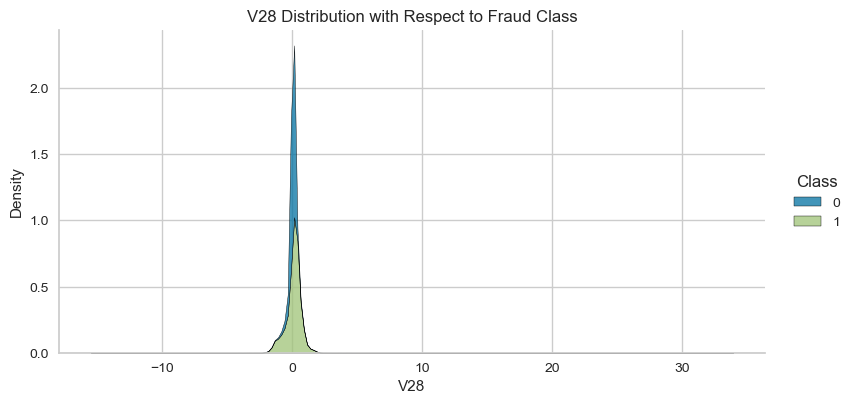

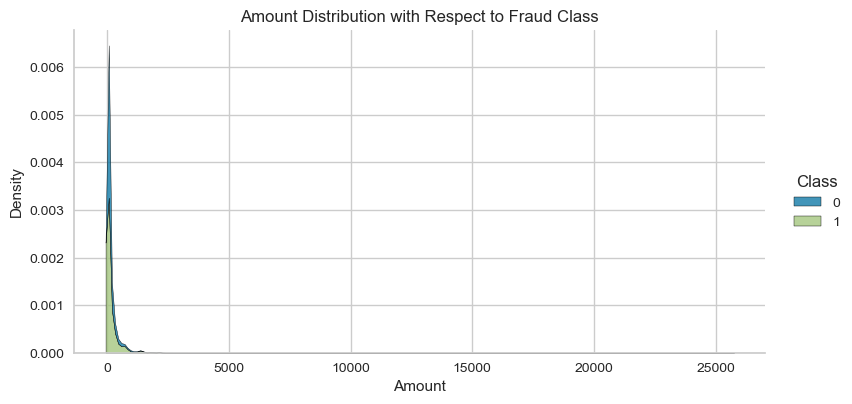

In [15]:

numeric_data_col = data._get_numeric_data().columns
for col in numeric_data_col:
    if col != "Class":
       sns.displot(data,
            x=col,
            hue="Class",
            # stat="density",
            common_norm=False,
            multiple="stack",
            height=4,
            aspect=2,
            kind="kde",
            ).set(title=col+" Distribution with Respect to Fraud Class")



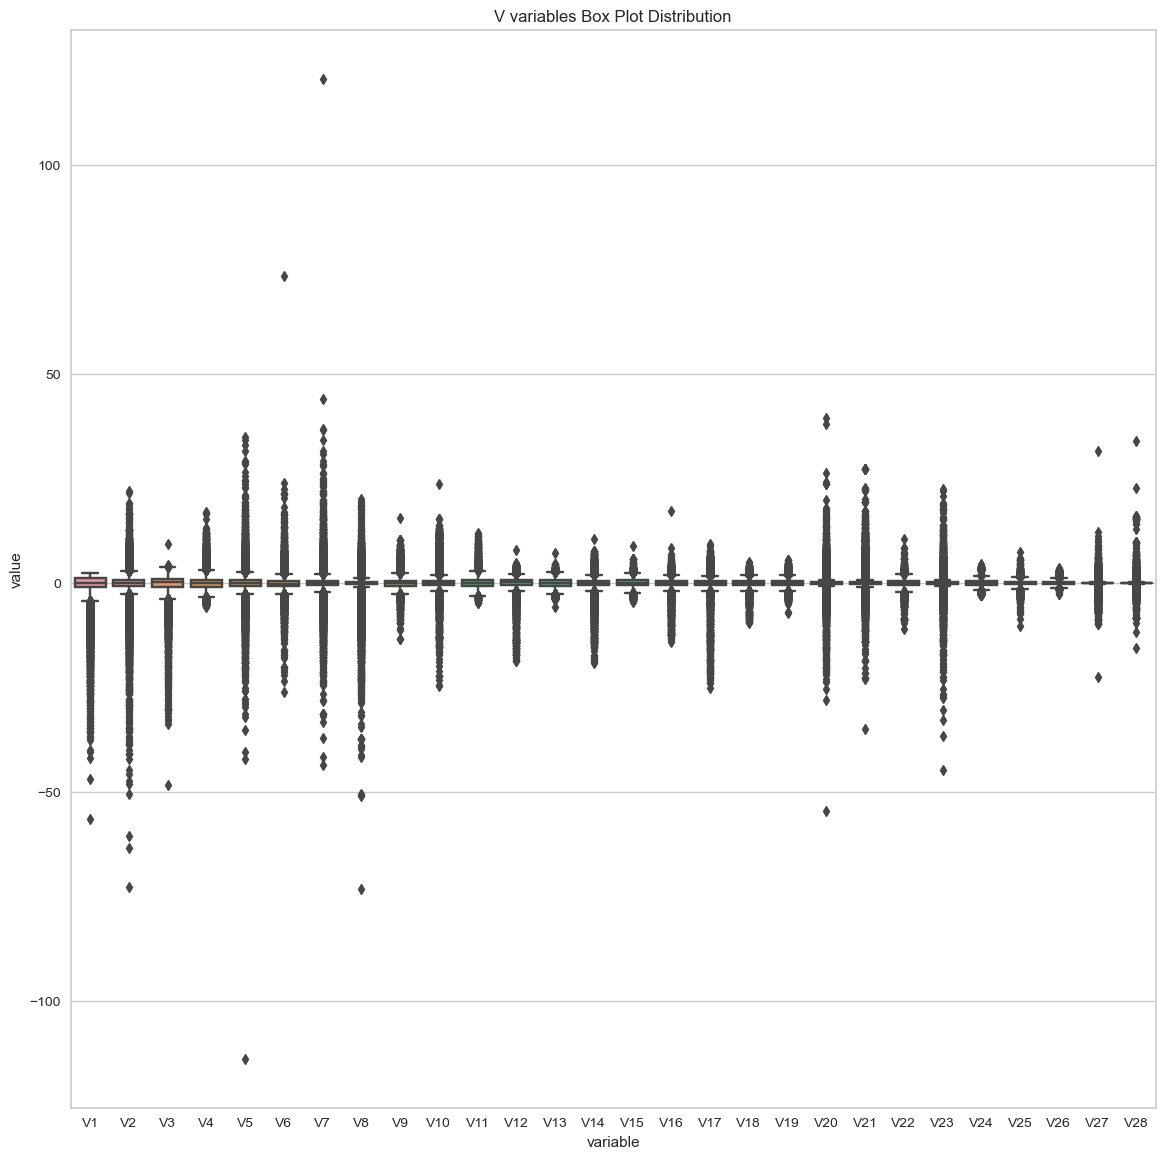

In [16]:

plt.figure(figsize=(14, 14))
vs = [col for col in data.columns if col.startswith("V")]
sns.boxplot(x="variable", y="value", data=pd.melt(data[vs])).set(title="V variables Box Plot Distribution")
plt.show()


In [17]:

# generate id column to keep track of the rows:
data["ID"] = range(1, len(data) + 1)
# check if ID is unique:
data["ID"].is_unique

True

Hard to detect outliers by inspecting the data, let's use IQR to detect outliers:

In [18]:

# we aim to calculate the IQR for each column in the DataFrame for the majority class:

# Define the threshold for outliers
threshold = 1.5

non_fraud = data[data["Class"] ==0]

independent_variables = data.drop(["Class","ID"],axis=1).columns

overall_outliers = []

# # Iterate over each column in the DataFrame
for col in independent_variables:

    # Calculate the IQR for the current column
    Q1 = non_fraud[col].quantile(0.25)
    Q3 = non_fraud[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Find the outliers in the current column
    outliers = non_fraud[(non_fraud[col] < lower_bound) | (non_fraud[col] > upper_bound)]["ID"]

    # Append the outliers to the overall list
    overall_outliers.extend(outliers.tolist())


#non fraud outliers:
len(set(overall_outliers))


138361

In [19]:

# copy the data to keep track of the original data:
outliers_removed = data.copy()

# drop the outliers:
outliers_removed = outliers_removed[~outliers_removed["ID"].isin(set(overall_outliers))]


<AxesSubplot: title={'center': 'Class Distribution after dropping outliers still heavily imbalanced'}>

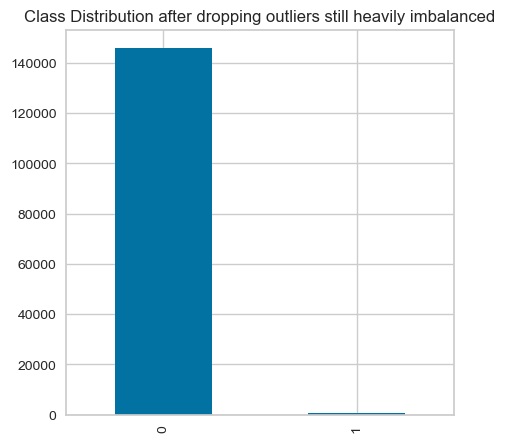

In [20]:

# check the class distribution after dropping outliers:
plt.figure(figsize=(5, 5))
outliers_removed["Class"].value_counts().plot(kind="bar",title="Class Distribution after dropping outliers still heavily imbalanced")


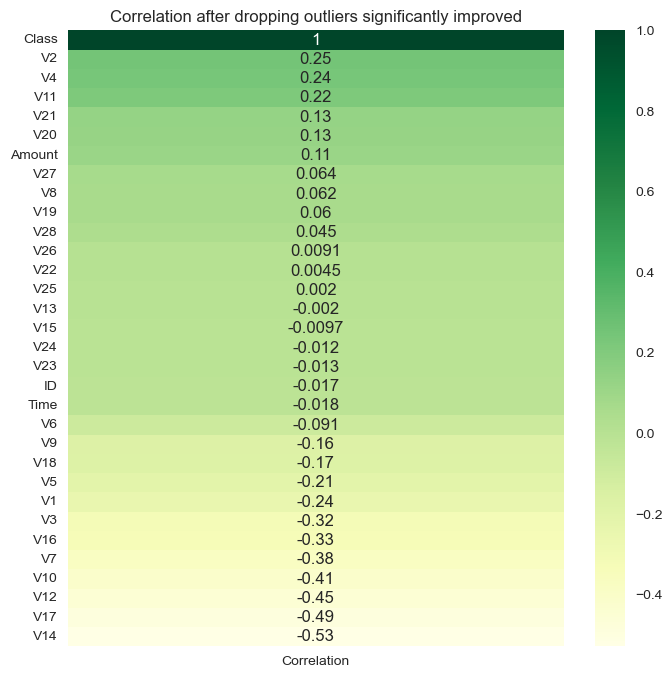

In [21]:


### show correlation after dropping outliers:
# Create a new DataFrame containing only the correlations between the target variable and the other variables
corr_with_target = data.corrwith(outliers_removed['Class'])

# Convert the Series to a DataFrame and drop any missing values
corr_df = pd.DataFrame(corr_with_target, columns=['Correlation'])
corr_df.dropna(inplace=True)

# sort the DataFrame by the correlation values:
corr_df.sort_values(inplace=True,by="Correlation",ascending=False)

plt.figure(figsize=(8, 8))

# Create a correlation plot using the new DataFrame
sns.heatmap(corr_df, cmap="YlGn", annot=True).set(title="Correlation after dropping outliers significantly improved")
# Show the plot
plt.show()



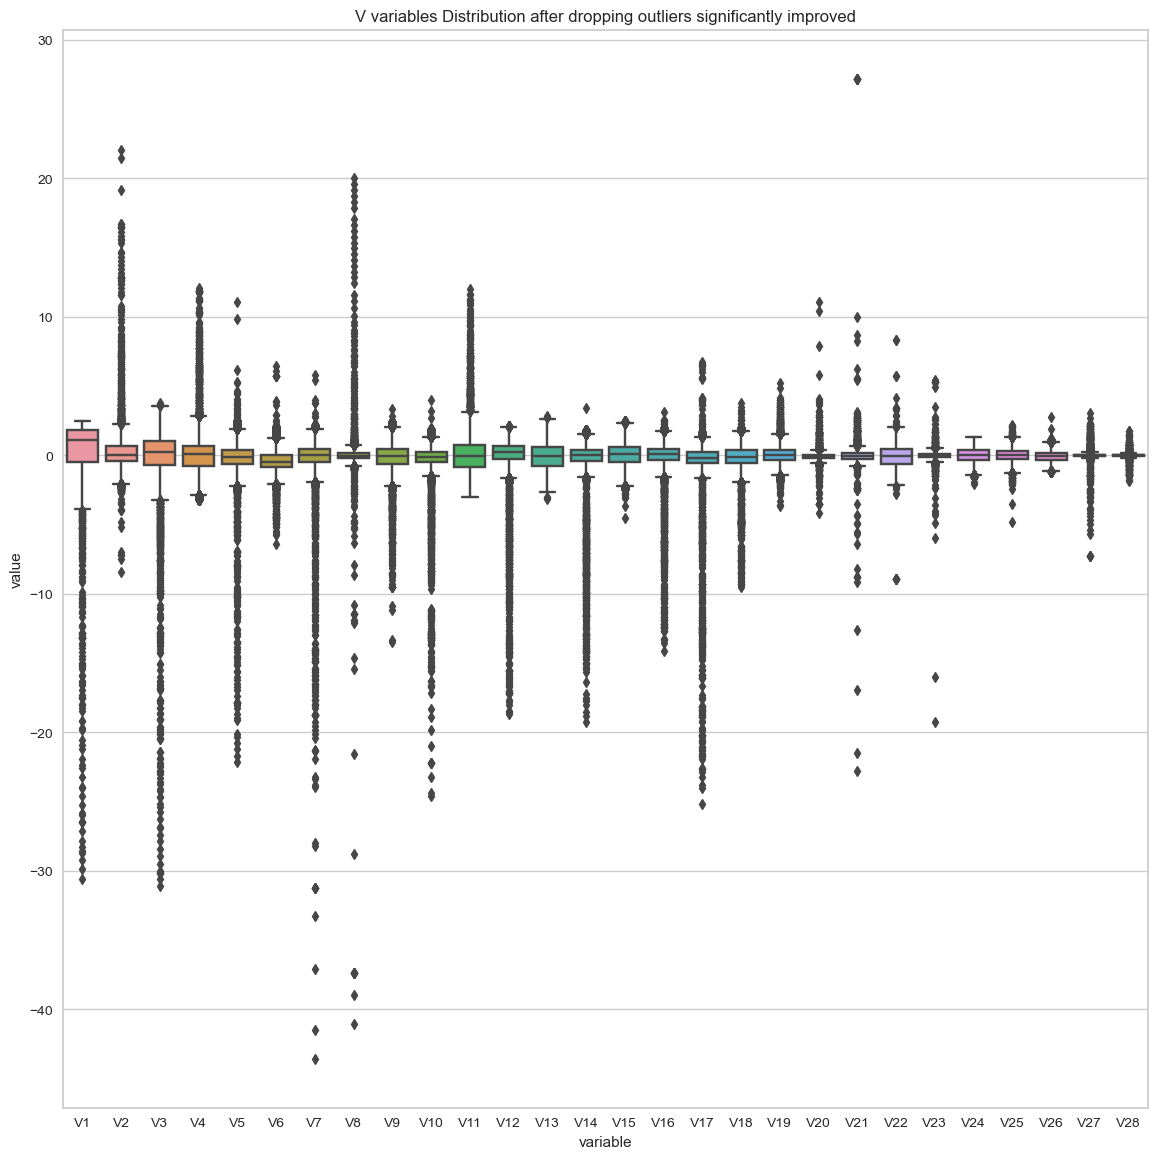

In [22]:
# visualize the correlation again:
plt.figure(figsize=(14, 14))
vs = [col for col in data.columns if col.startswith("V")]
sns.boxplot(x="variable", y="value", data=pd.melt(outliers_removed[vs])).set(title="V variables Distribution after dropping outliers significantly improved")
plt.show()


### Observations:
- Amount variable correlates highly compared to other variables with V20,V7,V6,V5,V4,V3,V2,V2.
- Time variable correlates negatively with V25,V15,V11,V3.
- Other variables don't correlate with each other or the Vs variables since they are reduced with PCA and represent interaction with features.
- Independent variables, V11, V4, V2, V21m V19, V20, V8 correlated positively with the independent variable
- The correlation between the target variable and the independent variables improved after dropping outliers, but still we might risk removing information from the data, its hard to decide to keep or remove outliers since many outliers can be informative outliers, and we can't take such decision without domain knowledge.
- The density distribution of the data for the numerical variables shows non-linear separation boundary by separation.
- Projecting data on 3D space with PCA shows that the data is not linearly separable and there is a pattern shared among or clusters in the data. for fraud class.
- The data is still heavily imbalanced.
- There are no missing values in the data.


# Modeling:
## Statistical Analysis:

In [23]:

data.drop("ID",axis=1,inplace=True,errors="ignore")

# Split the data into train and test sets with fixed random state:
X = data.drop(['Class'], axis=1)
y = data['Class']

# split data into training and testing:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [24]:

# Fit a logistic regression model using Statsmodels
X = sm.add_constant(X)  # Add a constant term to the feature matrix
result = sm.Logit(y, X).fit()

# Print the model summary:
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.003914
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               284807
Model:                          Logit   Df Residuals:                   284776
Method:                           MLE   Df Model:                           30
Date:                Sun, 26 Feb 2023   Pseudo R-squ.:                  0.6922
Time:                        10:50:23   Log-Likelihood:                -1114.8
converged:                       True   LL-Null:                       -3621.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.3917      0.249    -33.652      0.000      -8.880      -7.903
Time       -3.742e-06   2.26

In [25]:

statistical_results_as_frame = get_dataframe_from_summary(result)
statistical_results_as_frame[statistical_results_as_frame["P>|z|"] <= 0.000].style.background_gradient(cmap='summer')


## Simple Logistic Regression "Establishing a Baseline":

In [26]:

# Fit a logistic regression model using sklearn:
logistic_regression_model = LogisticRegression(random_state=12234526, penalty="l2", solver="newton-cholesky")
logistic_regression_model.fit(x_train, y_train)

# Predict on test data:
y_predict = logistic_regression_model.predict(x_test)

# classification report:
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



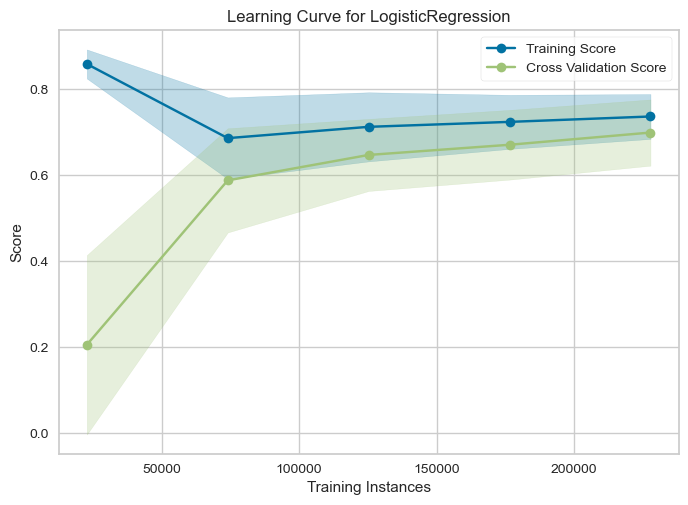

In [27]:

ge_learning_curve(logistic_regression_model, X, y, cv=5, scoring='f1')


X does not have valid feature names, but LogisticRegression was fitted with feature names
detected multi-dimensional feature importances but stack=False, using mean to aggregate them.


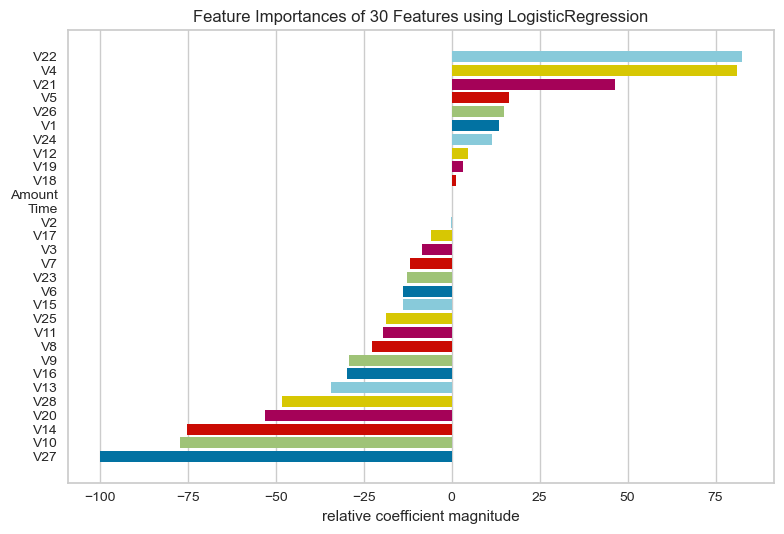

In [28]:

get_FeatureImportances(logistic_regression_model, x_train, y_train)


X does not have valid feature names, but LogisticRegression was fitted with feature names


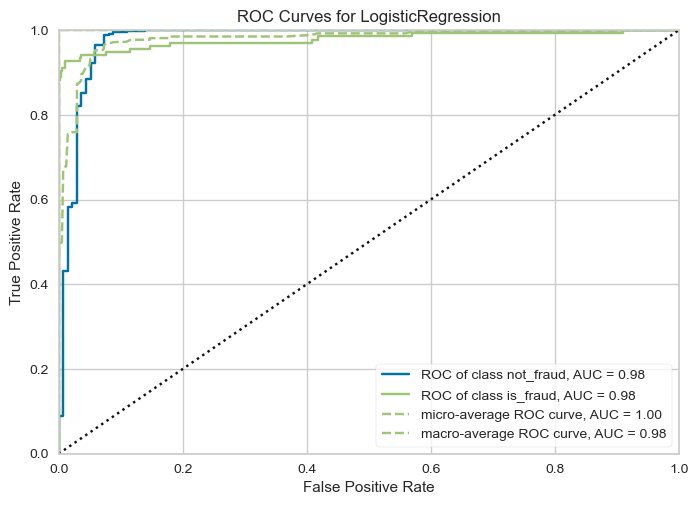

In [29]:

get_ROCAUC(logistic_regression_model, x_train, y_train, x_test, y_test, classes=["not_fraud", "is_fraud"])


X does not have valid feature names, but LogisticRegression was fitted with feature names


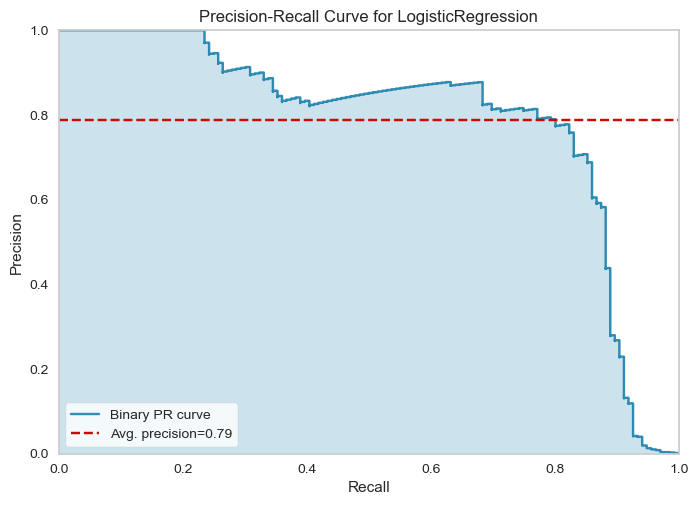

In [30]:

get_PrecisionRecallCurve(logistic_regression_model, x_train, y_train, x_test, y_test)


X does not have valid feature names, but LogisticRegression was fitted with feature names


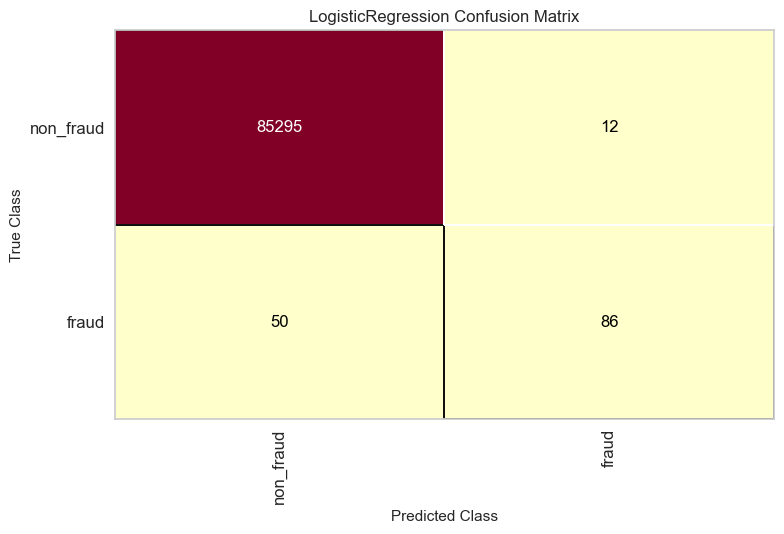

In [31]:

get_ConfusionMatrix(logistic_regression_model, x_train, y_train, x_test, y_test)


X does not have valid feature names, but LogisticRegression was fitted with feature names


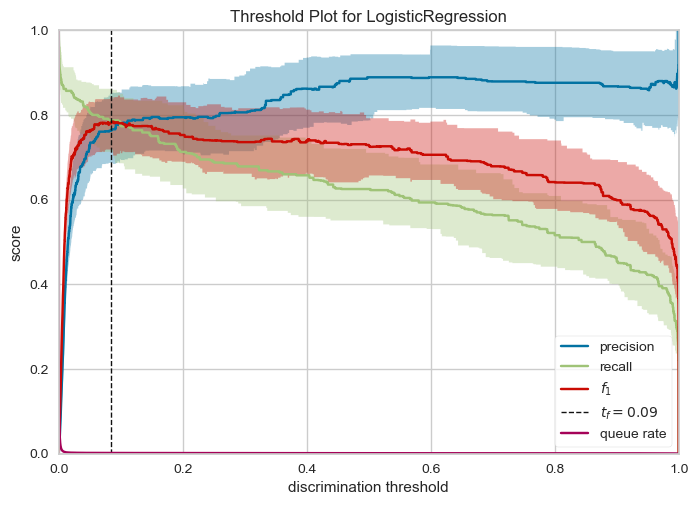

In [32]:

get_DiscriminationThreshold(logistic_regression_model, X, y)


### Feature Selection:
Let's try to improve the model by eliminating features and employing feature selection techniques:

In [33]:

rfe = RFE(logistic_regression_model)
fit = rfe.fit(X, y)
selected_features = X.columns[fit.support_].tolist()
selected_features


['V4',
 'V6',
 'V8',
 'V9',
 'V10',
 'V13',
 'V14',
 'V16',
 'V20',
 'V21',
 'V22',
 'V23',
 'V25',
 'V27',
 'V28']

In [34]:

reduced_features_train = x_train[selected_features]
reduced_features_test = x_test[selected_features]

logistic_regression_model.fit(reduced_features_train, y_train)

# Predict on test data:
y_predict_reduced = logistic_regression_model.predict(reduced_features_test)

# classification report:
print(classification_report(y_test, y_predict_reduced))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.64      0.73       136

    accuracy                           1.00     85443
   macro avg       0.93      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



X does not have valid feature names, but LogisticRegression was fitted with feature names


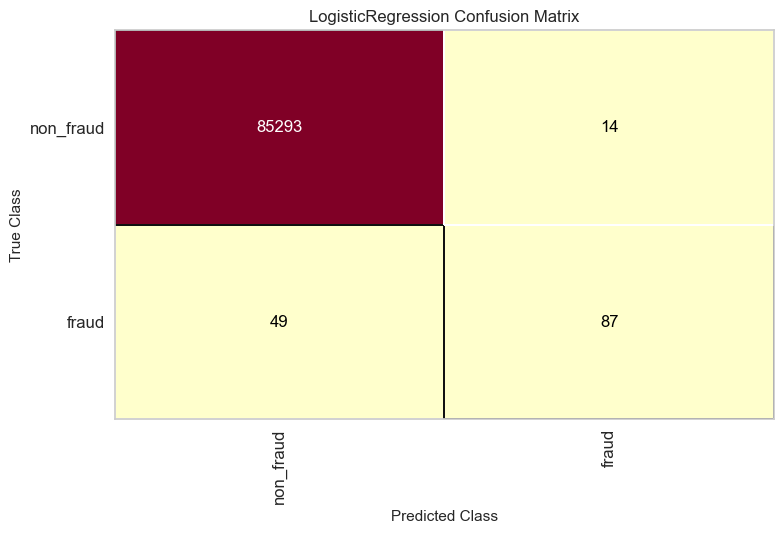

In [35]:

get_ConfusionMatrix(logistic_regression_model, reduced_features_train, y_train, reduced_features_test, y_test)


### Under-Sampling the Majority Class "Non-Fraud":
where we employ under sampling to balance the data and remove redundant data points in a highly imbalanced dataset:

In [36]:

# calculate the percentage of fraud cases:
value_counts = pd.Series(y).value_counts()
percentages = value_counts / len(y) * 100
# Print the result
print(percentages)


0    99.827251
1     0.172749
Name: Class, dtype: float64


In [37]:

# randomly under-sample the majority class with a given ratio:
rus = RandomUnderSampler(random_state=0, sampling_strategy = 0.4 / 100)
X_resampled, y_resampled = rus.fit_resample(X, y)
y_resampled.value_counts()


0    123000
1       492
Name: Class, dtype: int64

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36915
           1       0.91      0.77      0.83       133

    accuracy                           1.00     37048
   macro avg       0.95      0.88      0.92     37048
weighted avg       1.00      1.00      1.00     37048



X does not have valid feature names, but LogisticRegression was fitted with feature names


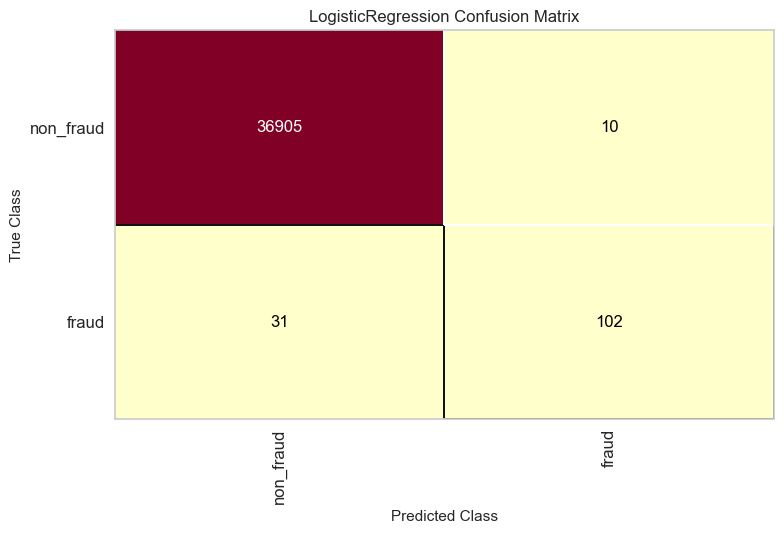

In [38]:

# split data into training and testing:
x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# fit model with same parameters and random state:
logistic_regression_model.fit(x_train_resampled, y_train_resampled)

# Predict on test data:
y_predict_resampled = logistic_regression_model.predict(x_test_resampled)

# classification report:
print(classification_report(y_test_resampled, y_predict_resampled))


get_ConfusionMatrix(logistic_regression_model, x_train_resampled, y_train_resampled, x_test_resampled, y_test_resampled)


### Observations:
- Fitting simple statistical linear model shows significant features that forms a good predictors of fraud class, V4,V8,V10,V13,V14,V20,V21,V22 and V27.
- Pseudo R-squ: 0.6922 shows that the model is a average fit for the data.
- Logistic regression model is a good baseline model for this dataset, with recall 0.63 for fraud class, we want to capture fraud cases as much as possible.
- Overall F1-score is 0.87, which is a good score for a baseline model but still what is relevant is the F1-score for fraud class since the data is heavily imbalanced.
- The learning curve for 5-fold cross validation shows that the model is not over-fitting.
- Most important features are V22,V4,V21,V5,V26,V1,V24,V12,V19,V18, Amount and Time almost has not affect on fraud class.
- ROC-AUC curve shows that the model is a good fit for the data but still irrelevant since the data is imbalanced.
- Model predicted 86 fraud transaction or the true-positive and missed 50 fraud transaction or the false-negative.
- Most important insight to highlight is probability threshold for predicting class fraud is 0.10, if we suspect with low probability if the model is fraud we can investigate further.
- Feature selection with elimination method resulting in 15 features increases the fraud detection by 1 only from 86 to 87.
- Under-sampling the majority class "Non-Fraud" to 0.4% of the data, increases the fraud detection from 87 to 102 but still we might risk losing information from the original distribution of the data we can not take such decision without further domain knowledge about the meaning of the variables introduced in the data.


## Complex Model:
Where we increase the complexity of the model by using ensemble methods:

In [39]:

# Set the scale_pos_weight parameter:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Create a LightGBM dataset object
dtrain = lgb.Dataset(x_train, label=y_train)

# Set the hyper-parameters help us approach the imbalanced data:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'scale_pos_weight': scale_pos_weight,

}

# Create an LGBMClassifier object
lightgbm_model = LGBMClassifier(
                              # **params,verbose=100,
    # n_estimators=len(X.columns),
    # is_unbalance=True,
    num_leaves=100,
    max_depth=100,
    # learning_rate=0.001,
    )

# Train the model
lightgbm_model.fit(x_train, y_train)

# Make predictions on the validation set
y_pred = lightgbm_model.predict(x_test)



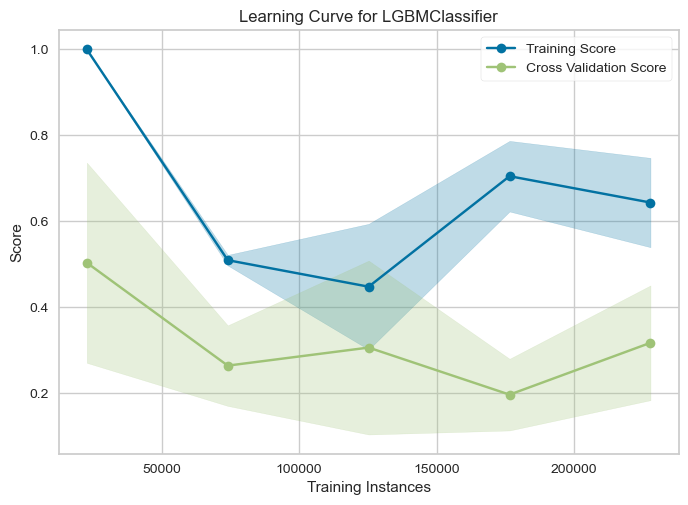

In [40]:

ge_learning_curve(lightgbm_model, X, y, cv=5, scoring='f1')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.81      0.82      0.82       136

    accuracy                           1.00     85443
   macro avg       0.91      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443



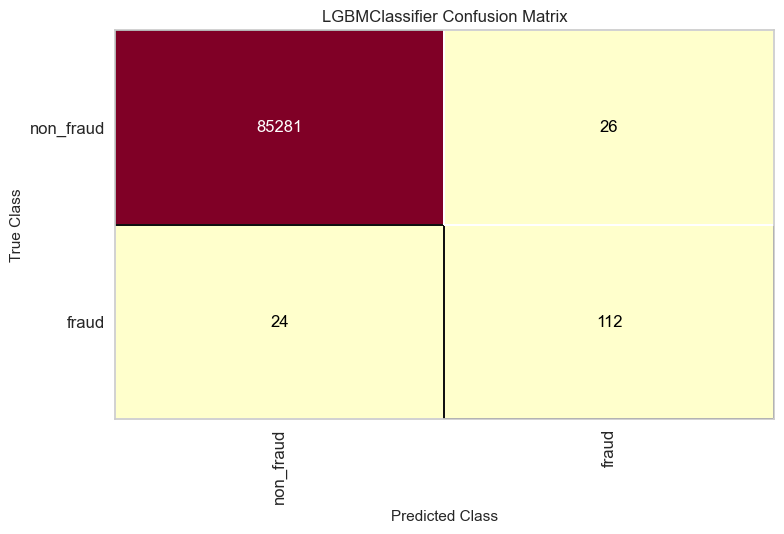

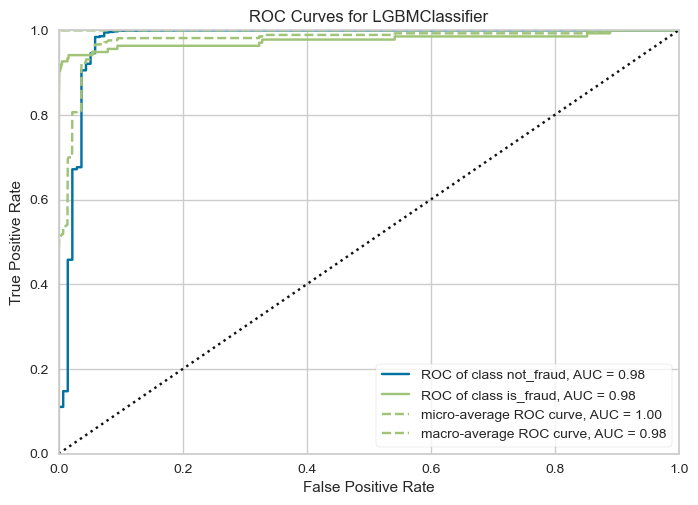

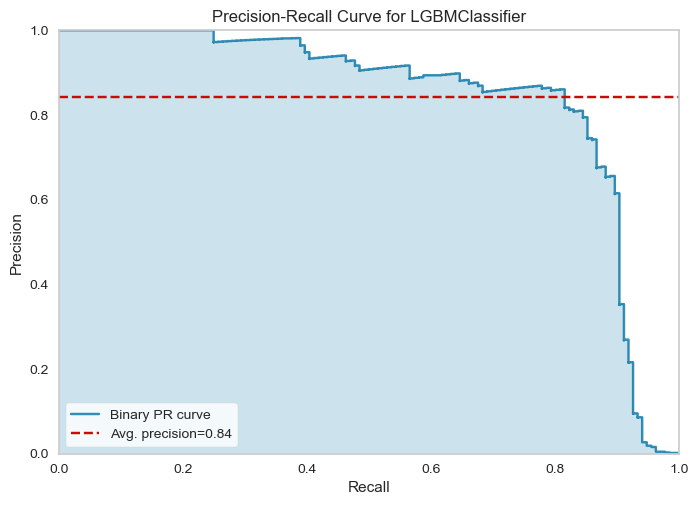

In [41]:

print(classification_report(y_test, y_pred))

get_ConfusionMatrix(lightgbm_model, x_train, y_train, x_test, y_test)

feature_importance_plot(lightgbm_model.feature_importances_, x_train.columns.tolist())

get_ROCAUC(lightgbm_model, x_train, y_train, x_test, y_test, classes=["not_fraud", "is_fraud"])

get_PrecisionRecallCurve(lightgbm_model, x_train, y_train, x_test, y_test)


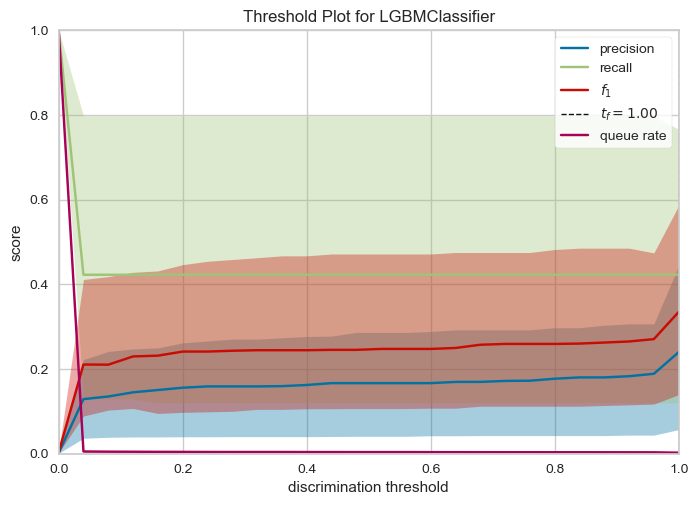

In [42]:

lightgbm_model_test = LGBMClassifier()
get_DiscriminationThreshold(lightgbm_model_test, x_test, y_test)


### Observations:
- Lightgbm model is able to capture more fraud transactions with F1 score of 0.82.
- Learning curve shows the model is unstable over 5-fold cross validation, it comes from the fact that the data is imbalanced.
- Frauds detection increase to 112 from 87 without under-sampling the majority class.
- Deciding a threshold for is difficult for lightgbm it's the case generally for boosting models, they do not offer a well calibrated probability as compared to logistic regression.


In [43]:

# first lets fit model on whole dataset:
lightgbm_model.fit(X_resampled, y_resampled)
calibrated_clf = CalibratedClassifierCV(lightgbm_model, cv='prefit', method='sigmoid')
calibrated_clf.fit(X_resampled, y_resampled)


CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(max_depth=100, num_leaves=100))

In [44]:

final_results = X_resampled.copy()
final_results['y'] = y_resampled
final_results['probability_fraud'] = calibrated_clf.predict_proba(X_resampled)[:, 1]
final_results['probability_non_fraud'] = calibrated_clf.predict_proba(X_resampled)[:, 0]
final_results['probability_fraud_logi'] = logistic_regression_model.predict_proba(X_resampled)[:, 1]
final_results['probability_non_fraud_logi'] = logistic_regression_model.predict_proba(X_resampled)[:, 0]


In [45]:

frauds_indexes = y_resampled.loc[y_resampled == 1].index
X_resampled_fraud = X_resampled.loc[frauds_indexes]
frauds_indexes_list = frauds_indexes.tolist()


# Explainable AI
Where we explain the model predictions performed by lightgbm model:

In [46]:

shap.initjs()
explainer = shap.TreeExplainer(lightgbm_model)
shap_values = explainer.shap_values(X_resampled, y_resampled, check_additivity=False)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


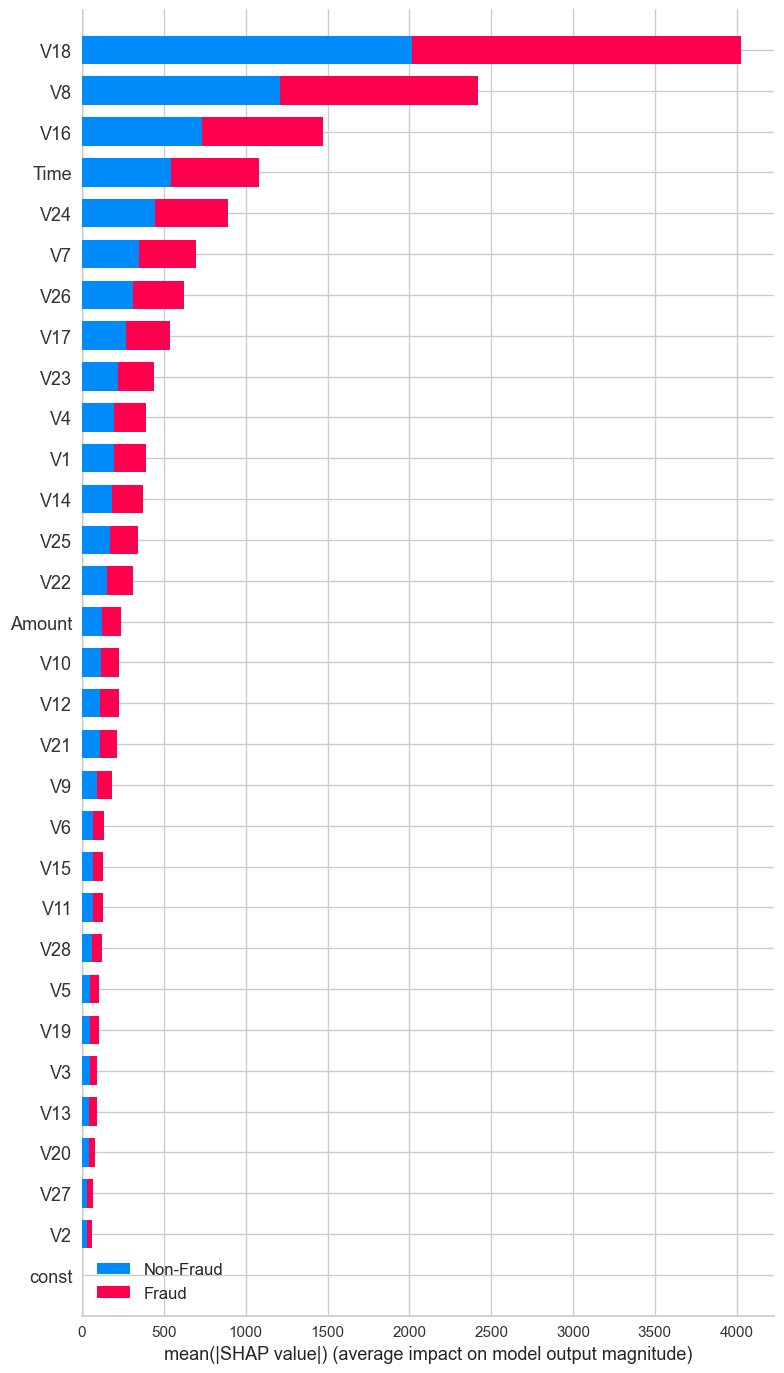

In [47]:

shap.summary_plot(shap_values, X_resampled, max_display=len(X.index),class_names=['Non-Fraud', 'Fraud'])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


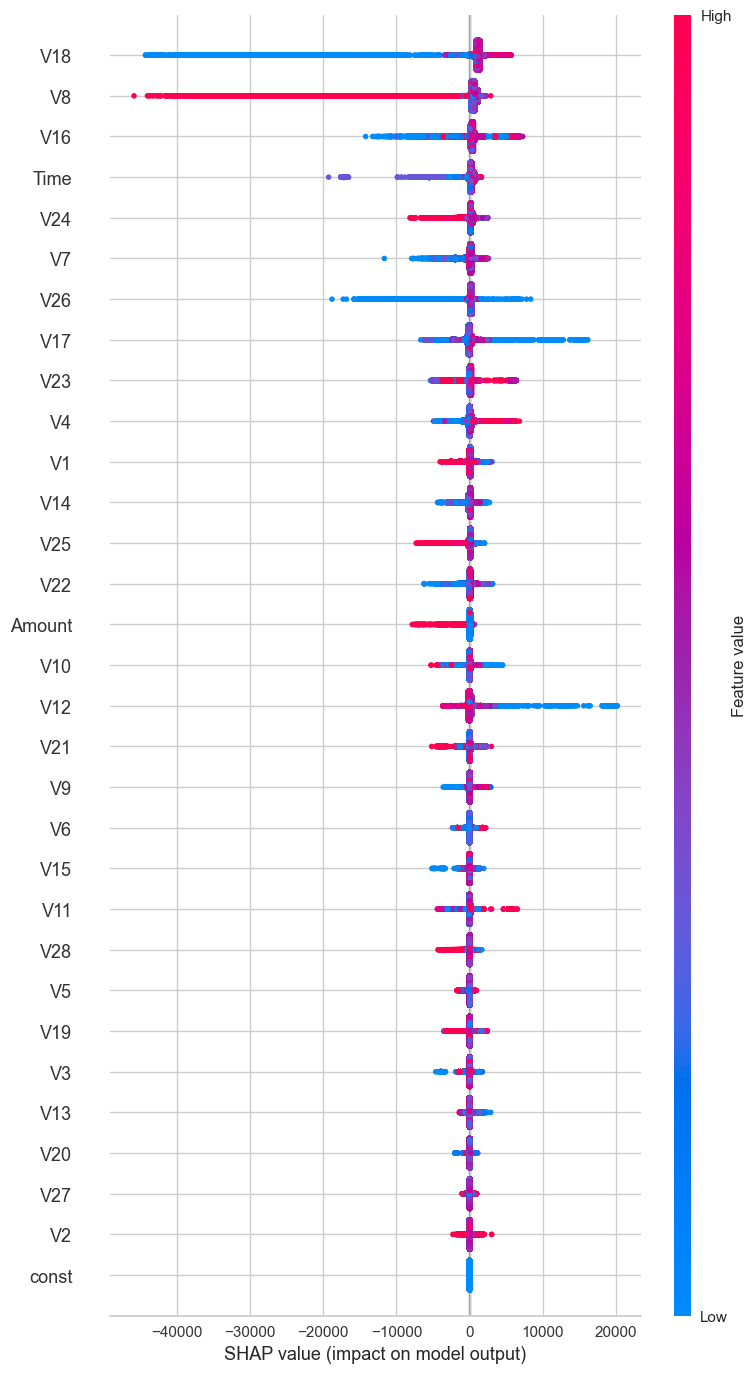

In [48]:

# impact of Fraud on the model:
shap.summary_plot(shap_values[1],
                  X_resampled,
                  max_display=len(X_resampled.index),
                  class_names=['Non-Fraud', 'Fraud'])


### Interaction between most impactful features for Fraud transactions:

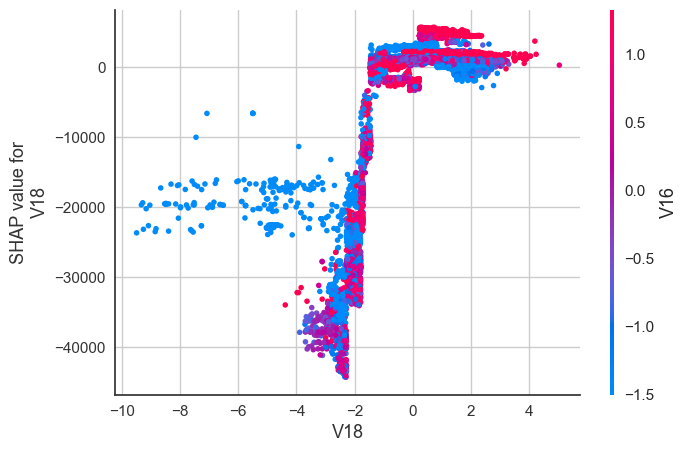

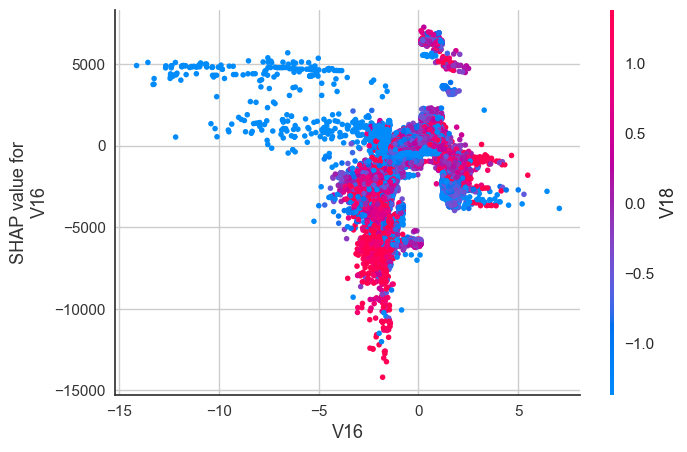

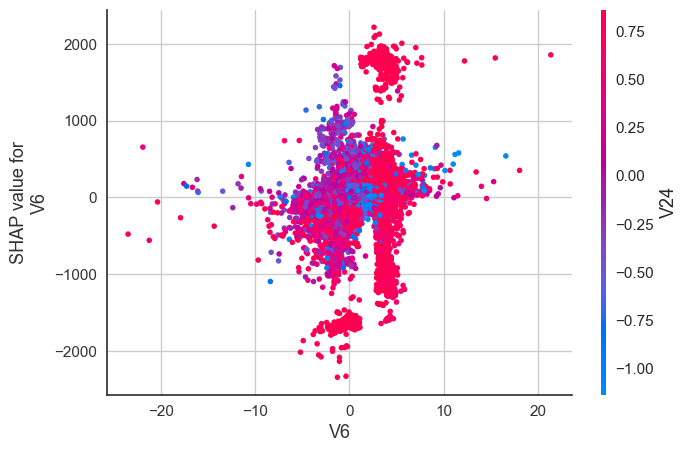

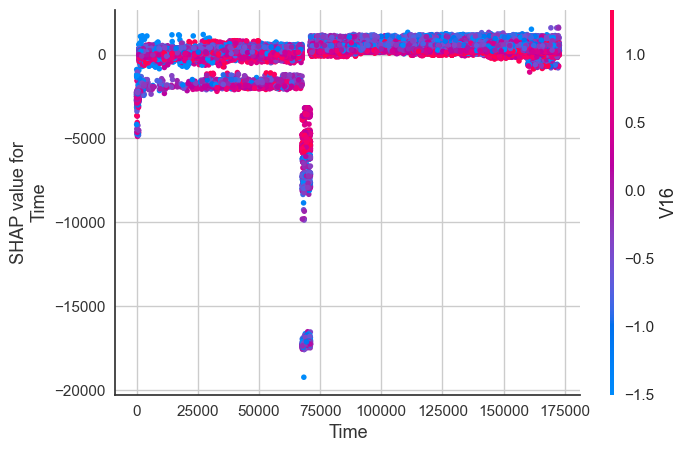

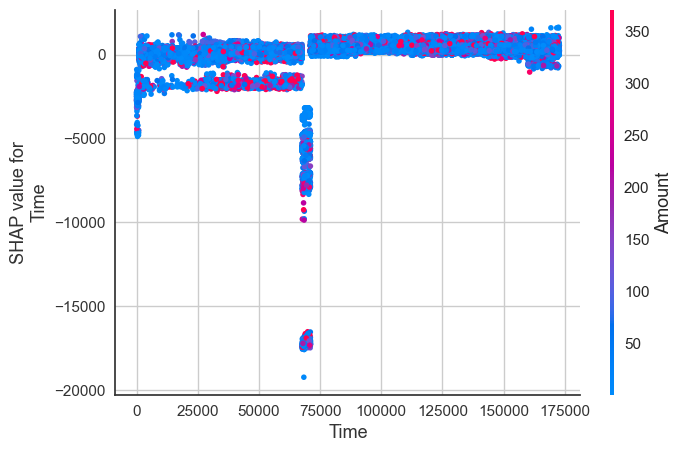

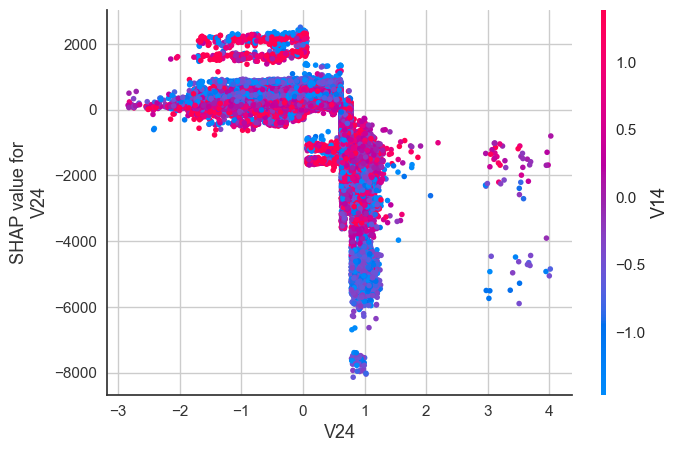

In [49]:


shap.dependence_plot("V18", shap_values[1], X_resampled)

shap.dependence_plot("V16", shap_values[1], X_resampled)

shap.dependence_plot("V6", shap_values[1], X_resampled)

shap.dependence_plot("Time", shap_values[1], X_resampled)

shap.dependence_plot("Time", shap_values[1], X_resampled, interaction_index="Amount")

shap.dependence_plot("V24", shap_values[1], X_resampled)



### Local Explanations of randomly chosen frauds transactions:

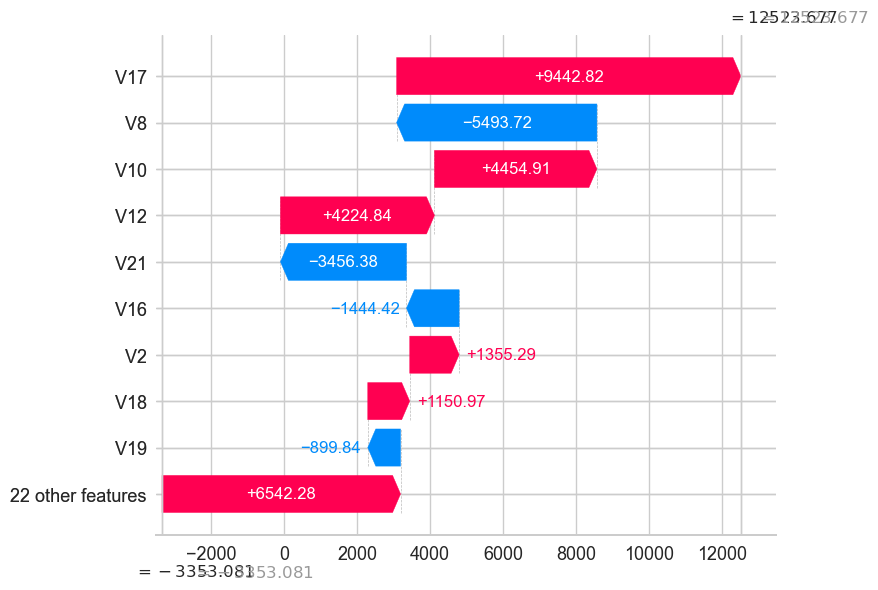

const                              1.000000
Time                          103808.000000
V1                                -4.517344
V2                                 2.500224
V3                                -4.013928
V4                                 1.189452
V5                                -2.486861
V6                                -1.413476
V7                                -4.245707
V8                                 1.265087
V9                                 1.168828
V10                               -4.513907
V11                                3.694711
V12                               -6.110443
V13                               -0.110522
V14                               -4.184555
V15                               -0.931035
V16                               -1.614718
V17                               -3.353180
V18                                0.236762
V19                                0.003896
V20                               -1.056162
V21                             

In [50]:

choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)


final_results.loc[choose_random_fraud]


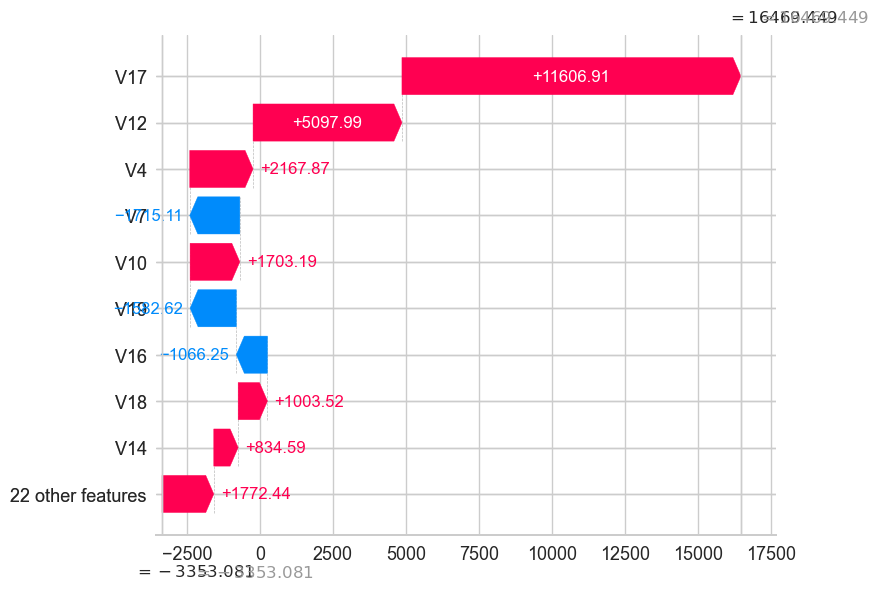

const                              1.000000
Time                          146344.000000
V1                                -0.099724
V2                                 2.795414
V3                                -6.423856
V4                                 3.247513
V5                                -1.632290
V6                                -2.766665
V7                                -2.312223
V8                                 0.961014
V9                                -1.896001
V10                               -4.919348
V11                                3.053654
V12                               -5.297811
V13                               -1.466030
V14                               -7.035880
V15                                1.997132
V16                               -3.836189
V17                               -2.515183
V18                               -0.864579
V19                                2.328927
V20                                0.340898
V21                             

In [51]:

choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)



final_results.loc[choose_random_fraud]


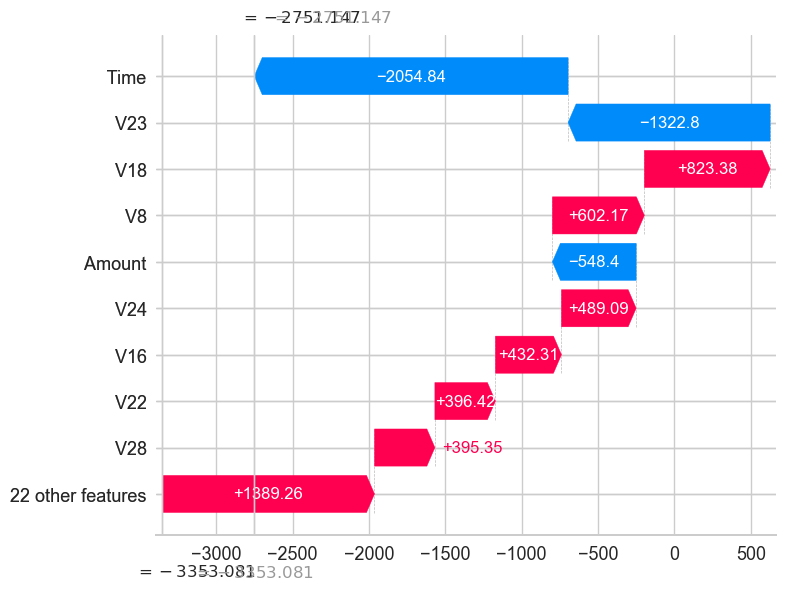

const                           1.000000
Time                          472.000000
V1                             -3.043541
V2                             -3.157307
V3                              1.088463
V4                              2.288644
V5                              1.359805
V6                             -1.064823
V7                              0.325574
V8                             -0.067794
V9                             -0.270953
V10                            -0.838587
V11                            -0.414575
V12                            -0.503141
V13                             0.676502
V14                            -1.692029
V15                             2.000635
V16                             0.666780
V17                             0.599717
V18                             1.725321
V19                             0.283345
V20                             2.102339
V21                             0.661696
V22                             0.435477
V23             

In [52]:


choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)

final_results.loc[choose_random_fraud]



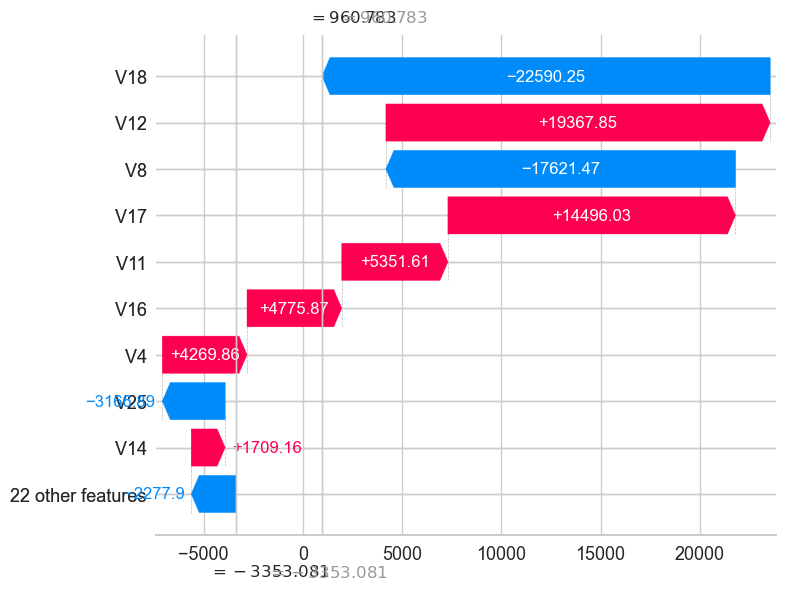

const                             1.000000
Time                          26585.000000
V1                              -19.856322
V2                               12.095893
V3                              -22.464083
V4                                6.115541
V5                              -15.148022
V6                               -4.346724
V7                              -15.648507
V8                               13.276805
V9                               -3.974162
V10                              -8.859194
V11                               5.730816
V12                              -8.088034
V13                               0.230825
V14                              -8.578973
V15                               0.000947
V16                              -6.947746
V17                             -13.472897
V18                              -4.940211
V19                               1.230143
V20                               1.582930
V21                               1.750730
V22        

In [53]:

choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)


final_results.loc[choose_random_fraud]


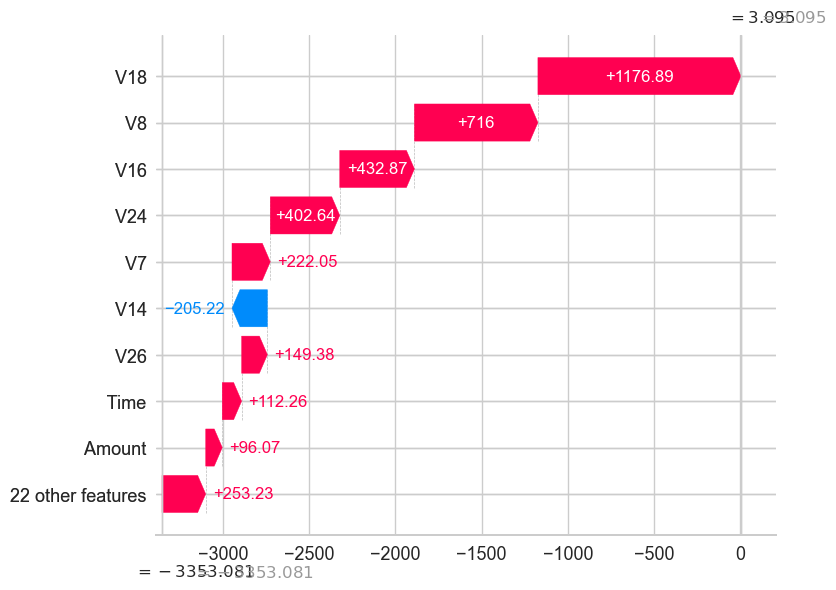

const                             1.000000
Time                          47545.000000
V1                                1.176716
V2                                0.557091
V3                               -0.490800
V4                                0.756424
V5                                0.249192
V6                               -0.781871
V7                                0.228750
V8                               -0.040840
V9                               -0.432111
V10                              -0.585778
V11                               2.281939
V12                               0.654567
V13                              -0.310379
V14                              -1.043705
V15                               0.513750
V16                               0.399178
V17                               1.143130
V18                               0.256014
V19                              -0.511210
V20                              -0.102772
V21                              -0.062166
V22        

In [54]:

choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)

final_results.loc[choose_random_fraud]


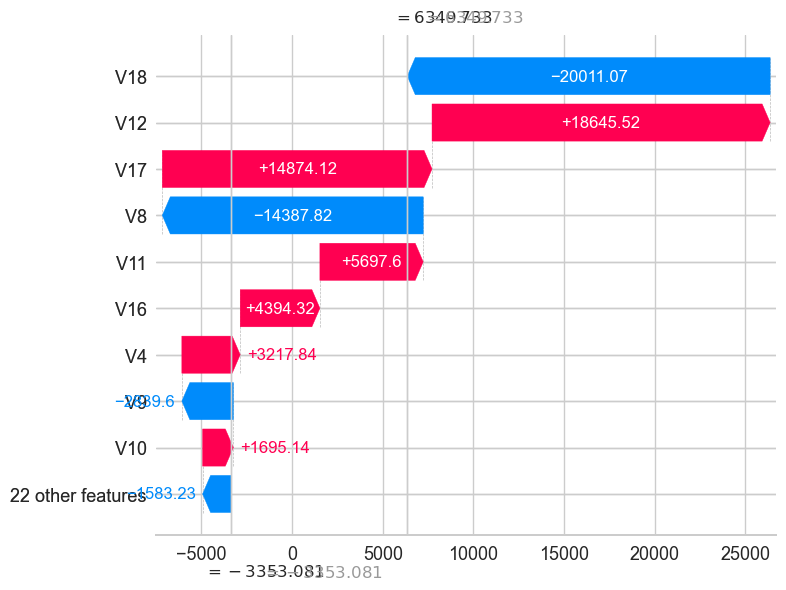

const                         1.000000e+00
Time                          9.382400e+04
V1                           -3.632809e+00
V2                            5.437263e+00
V3                           -9.136521e+00
V4                            1.030723e+01
V5                           -5.421830e+00
V6                           -2.864815e+00
V7                           -1.063409e+01
V8                            3.018127e+00
V9                           -4.891640e+00
V10                          -1.123505e+01
V11                           8.788784e+00
V12                          -1.855370e+01
V13                          -3.395334e-01
V14                          -1.562319e+01
V15                          -1.889786e-01
V16                          -1.242796e+01
V17                          -2.015905e+01
V18                          -6.888891e+00
V19                           2.586093e+00
V20                           1.354065e+00
V21                           2.309880e+00
V22        

In [55]:

choose_random_fraud= random.sample(frauds_indexes_list, 1)[0]
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][choose_random_fraud],
                                       X_resampled.iloc[choose_random_fraud],
                                       X_resampled.columns)

final_results.loc[choose_random_fraud]


### Insight of real values and Explainable AI values:

### Prepare the data first:

In [56]:

# Slice by fraud transactions:
fraud_final_results = final_results[final_results["y"] == 1]

# validate that we are dealing with fraud transactions only:
fraud_final_results.index.equals(frauds_indexes)

# get shap values of fraud transactions only, 1 here refers to fraud transaction or label:
shap_values_fraud = shap_values[1][fraud_final_results.index]

shap_values_fraud = pd.DataFrame(shap_values_fraud, columns=X_resampled.columns)
shap_values_fraud.drop(columns=['const'], inplace=True,errors='ignore')
fraud_final_results.drop(columns=['const'], inplace=True,errors='ignore')

list_columns = shap_values_fraud.columns.tolist()
new_columns = [column + "_shap" for column in list_columns]
shap_values_fraud.columns = new_columns

# to make sure we are dealing with the same indexes, and help us merge the dataframes:
fraud_final_results = fraud_final_results.reset_index()
shap_values_fraud["index"] = fraud_final_results["index"]
overall_final  = fraud_final_results.merge(shap_values_fraud, on="index")



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:


overall_final["probability_fraud"] = overall_final["probability_fraud"].apply(lambda x: round(x, 4))
overall_final["probability_fraud"] = overall_final["probability_fraud"].astype(float)


In [58]:

# shap values should be in the positive range, it means its effecting fraud probability positively:
mean_series = overall_final.mean(axis=0)
mean_series = mean_series.sort_values(ascending=False)
mean_series


index       123245.500000
Time         80746.806911
V17_shap      8510.094384
V12_shap      8293.768162
V4_shap       2224.738310
                ...      
V9_shap       -390.242928
V19_shap      -448.767418
V7_shap       -555.546820
V8_shap      -3842.413947
V18_shap     -9396.813096
Length: 66, dtype: float64

[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V7')]

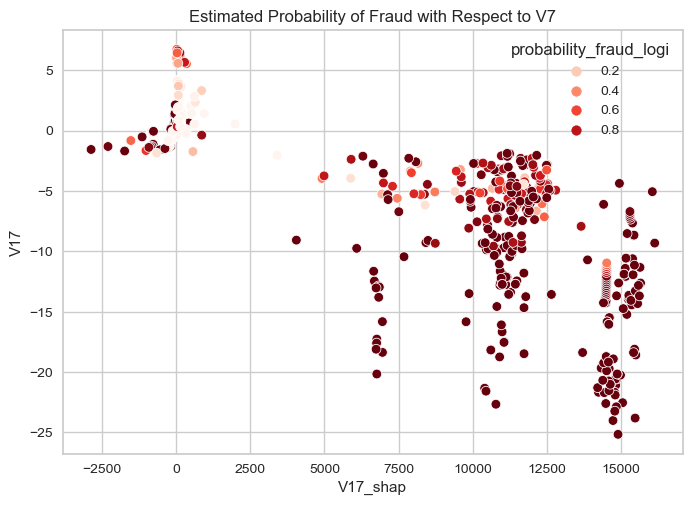

In [93]:


sns.scatterplot(overall_final,
                y="V17",
                x="V17_shap",
                hue="probability_fraud_logi",
                palette="Reds"
             ).set(title="Estimated Probability of Fraud with Respect to V7")


[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V12')]

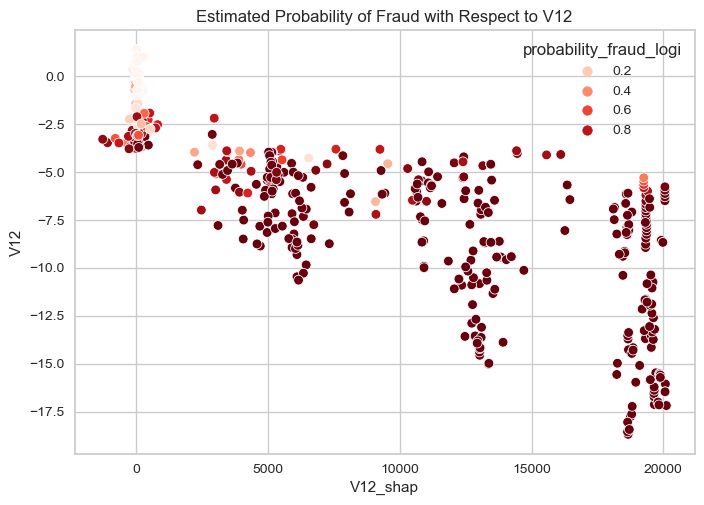

In [92]:

sns.scatterplot(overall_final,
                y="V12",
                x="V12_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V12")


[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V4')]

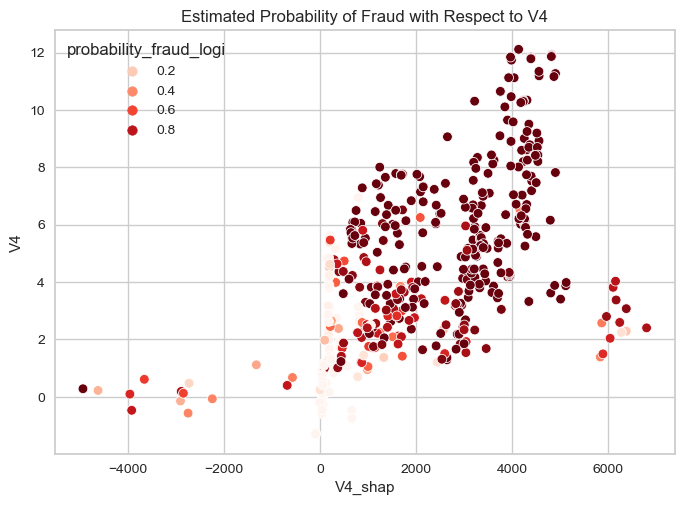

In [90]:

sns.scatterplot(overall_final,
                y="V4",
                x="V4_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V4")


[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V10')]

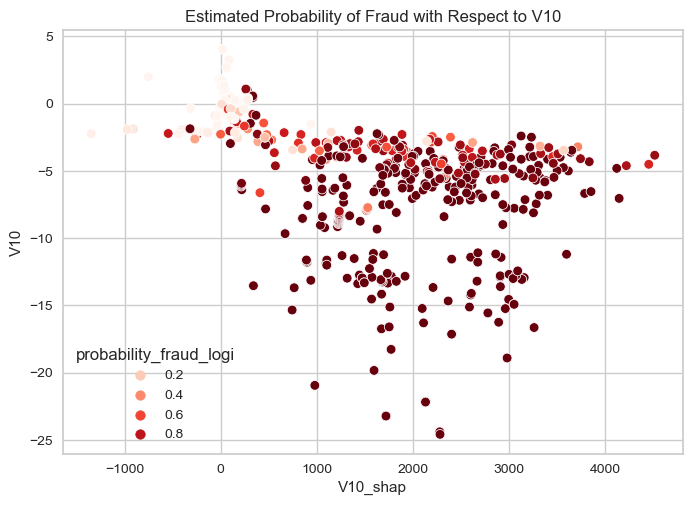

In [86]:



sns.scatterplot(overall_final,
                y="V10",
                x="V10_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V10")





[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to V11')]

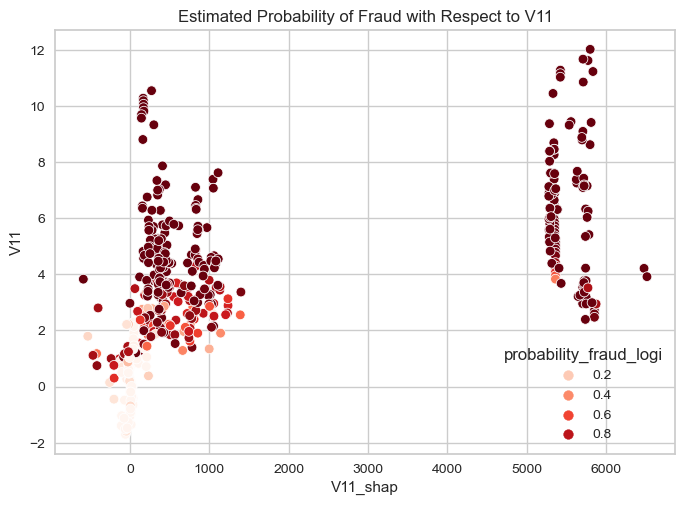

In [87]:


sns.scatterplot(overall_final,
                y="V11",
                x="V11_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to V11")





[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to Time')]

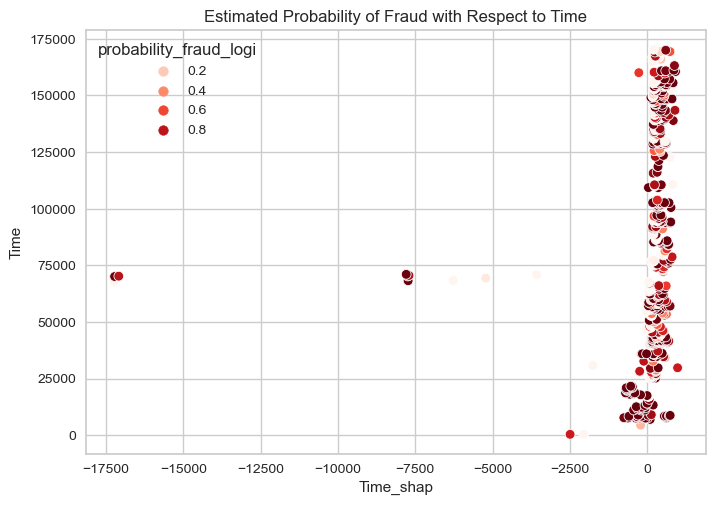

In [88]:


sns.scatterplot(overall_final,
                y="Time",
                x="Time_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to Time")




[Text(0.5, 1.0, 'Estimated Probability of Fraud with Respect to Time')]

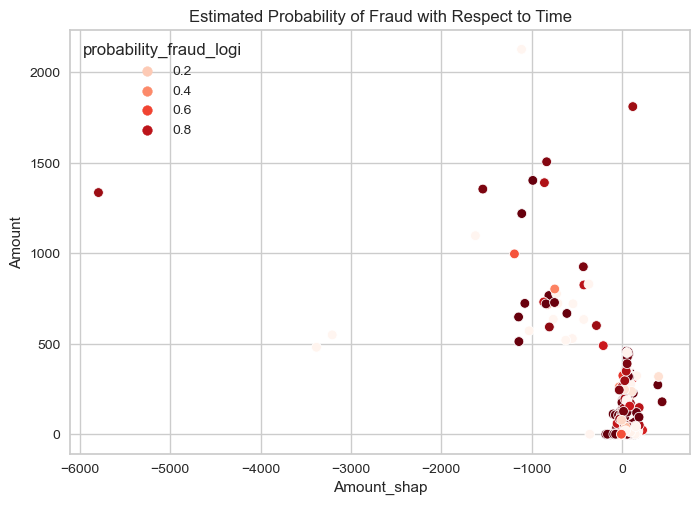

In [89]:



sns.scatterplot(overall_final,
                y="Amount",
                x="Amount_shap",
                hue="probability_fraud_logi",
                palette="Reds"
                ).set(title="Estimated Probability of Fraud with Respect to Time")





### Observations
- Features V18,V8,V16,TIME and V7 has the most impact on the probability of fraud.
- The lower the value of V18 the lower the probability of fraud almost most fraud transactions predicted fraud influenced by lower value of V18.
- The higher the value of V8 the lower the probability of fraud, second-largest impact on the probability of fraud.
- The higher the value of V4 and V23 the higher the probability of fraud.
- The higher the amount of transaction the lower the probability of fraud but few example are predicted fraud impacted by amount feature.
- I sampled few examples that predicted as fraud and explained them locally with V12 and V17 pushed the prediction toward fraud with higher magnitude from the expected value of fraud, interestingly the opposite happened with 12 pushed the prediction toward non-fraud with higher magnitude from the expected value of non-fraud.
- Interestingly when visualizing the actual values of most impacted features that influences the probability of fraud we can see that:
    - We can easily decide fraud transaction with high probability of fraud with V17 and V12 actual value being less than -5 with high shap values impact greater than 5K magnitude from the base value.
    - The higher V4 the higher the impact of the model in predicting fraud.
    - The higher value of V11 when its values is positive integer and greater or equal to 3 the higher the impact of the model in predicting fraud.
    - Time of the transaction almost has no effect in distinguishing fraud transactions from non-fraud transactions.

# Conclusion, discussion  and Actionable Insights:


- The goal is to detect fraud from a series of transactions, the problem is very challenging as the data is highly imbalanced, tho I have came up with actionable insight from the data after investigating it and building multiple models and comparing them, the first actionable insight is of course is related to how certain we are in detecting fraud from population of transactions, we now logist regression model is efficient in its probability calibration so it outputs well calibrated probability output for this reason I have chosen this model to decide weather a transaction is a fraud or not based on the probability output, unsurprisingly the probability threshold is 0.1, so if the probability of a transaction being a fraud is greater or equal to 0.1 then we will consider it as a fraud.
- The second actionable insight is related to the features that are most important in detecting fraud, the lower the value of V18 the lower the probability of fraud almost most fraud transactions predicted fraud influenced by lower value of V18.
- thirdly interstage transaction that has higher the value of V8 which lower the probability of fraud.
-  We can easily decide fraud transaction with high probability of fraud with V17 and V12 actual value being less than -5 with high shap values impact greater than 5K magnitude from the base value.
- The higher V4 the higher the impact of the model in predicting fraud.
- The higher value of V11 when its values is positive integer and greater or equal to 3 the higher the impact of the model in predicting fraud.
- Time of the transaction almost has no effect in distinguishing fraud transactions from non-fraud transactions.





